### *cis*- and *trans*-QTL mapping with tensorQTL

This notebook provides examples for running *cis*- and *trans*-QTL mapping with tensorQTL, using open-access data from the [GEUVADIS](https://www.ebi.ac.uk/arrayexpress/experiments/E-GEUV-1/) project.

#### Requirements
An environment configured with a GPU and ~50GB of memory.

#### Test dataset

*Note: these files are provided for testing/benchmarking purposes only. They do not constitute an official release from the GEUVADIS project, and no quality-control was applied.*

Genotypes in PLINK2 format (chr18 only), and normalized expression data are available [in this repository](./data/); the full dataset is available at [gs://gtex-resources/test_data/geuvadis](https://console.cloud.google.com/storage/browser/gtex-resources/test_data/geuvadis) ([requester pays](https://cloud.google.com/storage/docs/requester-pays)).

In [11]:
import os
os.chdir('/cluster2/home/futing/Project/HiCQTL/merged/CRC')
import pandas as pd
import torch
import tensorqtl
import matplotlib.pyplot as plt
from tensorqtl import pgen, cis, trans, post
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch: {torch.__version__} (CUDA {torch.version.cuda}), device: {device}")
print(f"pandas: {pd.__version__}")

torch: 2.6.0+cu124 (CUDA 12.4), device: cuda
pandas: 1.5.3


#### 预处理

In [2]:
expression_file = '/cluster2/home/futing/Project/HiCQTL/merged/CRC/phenotype/CRC_Jun26.bed'
ex = pd.read_csv(expression_file, sep='\t')
filtered = ex.loc[~ex.iloc[:, 3:].isna().all(axis=1)]
filtered.rename(columns={'chrom':'chr'}, inplace=True)
filtered.loc[:,'gene'] = filtered.index
filtered = filtered[['chr', 'start', 'end', 'gene'] + list(filtered.columns[3:-1])]
filtered.loc[:,'chr'] = filtered.loc[:,'chr'].str.replace('chr', '', regex=False)
filtered.to_csv('./phenotype/CRC_Jun26fil.bed', sep='\t', index=False)

/tmp/ipykernel_16270/2425645377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.rename(columns={'chrom':'chr'}, inplace=True)
/tmp/ipykernel_16270/2425645377.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered.loc[:,'gene'] = filtered.index


#### 读入数据

In [12]:


# define paths to data
plink_prefix_path = '/cluster2/home/futing/Project/HiCQTL/merged/CRC/genotype/CRC'
expression_bed = '/cluster2/home/futing/Project/HiCQTL/merged/CRC/phenotype/expr.bed'
# covariates_file = 'genotype_pc5.eigenvec.txt'
covariates_file ='/cluster2/home/futing/Project/HiCQTL/merged/CRC/covariate/covariate.txt'
prefix = 'CRC'
# load phenotypes and covariates
phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)
covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T

# PLINK reader for genotypes
pgr = pgen.PgenReader(plink_prefix_path)
genotype_df = pgr.load_genotypes()
variant_df = pgr.variant_df

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:409: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phenotype_df = pd.read_csv(phenotype_bed, sep='\t', index_col=3, dtype={'#chr':str, '#Chr':str})


In [42]:
phenotype_df=phenotype_df.loc[:,covariates_df.index]

In [14]:
# 每个样本SNP型，SNP的位置，表型数据，协方差矩阵
genotype_df.shape,variant_df.shape,phenotype_df.shape,phenotype_pos_df.shape,covariates_df.shape

((10405202, 32), (10405202, 3), (26907, 32), (26907, 3), (32, 7))

In [16]:
phenotype_pos_df.head()

,chr,start,end
gene,,,
ENSG00000243485,1,29554,31109
ENSG00000237613,1,34554,36081
ENSG00000186092,1,65419,71585
ENSG00000238009,1,89295,133723
ENSG00000239945,1,89551,91105


### *cis*-QTL: nominal p-values for all variant-phenotype pairs

In [15]:
# map all cis-associations (results for each chromosome are written to file)

# all genes
cis.map_nominal(genotype_df, variant_df, phenotype_df, phenotype_pos_df, prefix, covariates_df=covariates_df)

# genes on chr18
# cis.map_nominal(genotype_df, variant_df,
#                 phenotype_df.loc[phenotype_pos_df['chr'] == 'chr18'],
#                 phenotype_pos_df.loc[phenotype_pos_df['chr'] == 'chr18'],
#                 prefix, covariates_df=covariates_df)

cis-QTL mapping: nominal associations for all variant-phenotype pairs
  * 32 samples
  * 26907 phenotypes
  * 7 covariates
  * 10405202 variants
  * cis-window: ±1,000,000
    ** dropping 17433 phenotypes on chrs. without genotypes
    ** dropping 1024 constant phenotypes
  * checking phenotypes: 8450/8450
  * Computing associations
    Mapping chromosome 12
    processing phenotype 447/8450    time elapsed: 0.06 min
    * writing output
    Mapping chromosome 13
    processing phenotype 906/8450    time elapsed: 0.35 min
    * writing output
    Mapping chromosome 14
    processing phenotype 1694/8450    time elapsed: 0.47 min
    * writing output
    Mapping chromosome 15
    processing phenotype 2484/8450    time elapsed: 0.84 min
    * writing output
    Mapping chromosome 16
    processing phenotype 3556/8450    time elapsed: 1.08 min
    * writing output
    Mapping chromosome 17
    processing phenotype 4926/8450    time elapsed: 1.56 min
    * writing output
    Mapping chromos

In [45]:
# load results
pairs_df = pd.read_parquet(f'{prefix}.cis_qtl_pairs.22.parquet')
pairs_df.head()

,phenotype_id,variant_id,start_distance,end_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se
0,574263,chr22_46085605_C_T,-999396,-1004395,0.5000,32,32,NaN,NaN,NaN
1,574263,rs8135478,-998896,-1003895,0.8000,2,13,0.948003,0.013202,0.200238
2,574263,chr22_46086842_G_C,-998159,-1003158,0.5000,32,32,NaN,NaN,NaN
3,574263,rs9626891,-997933,-1002932,0.5625,31,28,0.604737,-0.117371,0.223645
4,574263,chr22_46087271_G_A,-997730,-1002729,0.5000,32,32,NaN,NaN,NaN


In [46]:
counts = pairs_df['phenotype_id'].value_counts()
print(counts)

574553    11185
574552    11182
574551    11174
574554    11174
574549    11171
          ...  
574974     4513
574975     4492
574976     4468
574977     4434
574978     4417
Name: phenotype_id, Length: 716, dtype: int64


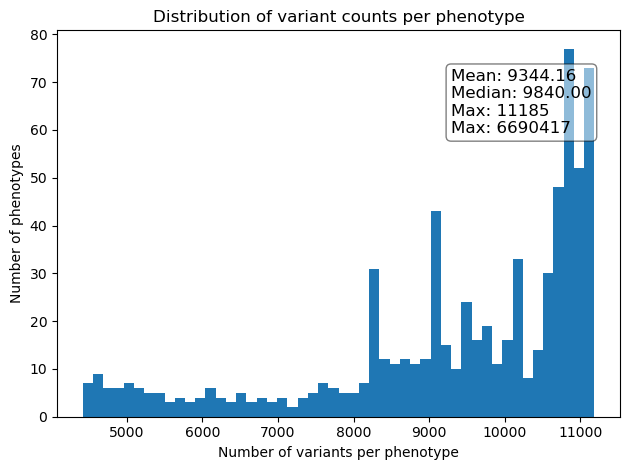

In [47]:
import matplotlib.pyplot as plt
counts.plot(kind='hist', bins=50)
plt.xlabel("Number of variants per phenotype")
plt.ylabel("Number of phenotypes")
plt.text(0.7, 0.9, f"Mean: {counts.mean():.2f}\nMedian: {counts.median():.2f}\nMax: {counts.max()}\nMax: {counts.sum()}",
		 transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.title("Distribution of variant counts per phenotype")
# plt.grid(True)
plt.tight_layout()
plt.savefig(f'{prefix}.cis_qtl_pairs10k.22.6co.hist.png', dpi=300)

### *cis*-QTL: empirical p-values for phenotypes

In [48]:
phenotype_df.fillna(0, inplace=True)
phenotype_df.isna().sum()

09-376            0
11-1026           0
11-1074           0
11-1074_Normal    0
11-51             0
11-51_Normal      0
11-52             0
11-63             0
11-63_Normal      0
11-927            0
11-983            0
12-251            0
13-1317           0
13-1320           0
13-1321           0
13-1334           0
13-1410           0
13-1413           0
13-1483           0
13-257            0
13-542            0
13-545            0
14-1083           0
14-1251           0
14-132            0
14-151            0
14-258            0
14-275            0
14-326            0
14-442            0
14-494            0
14-810            0
dtype: int64

In [17]:
# all genes
cis_df = cis.map_cis(genotype_df, variant_df, phenotype_df, phenotype_pos_df, covariates_df=covariates_df)

# genes on chr18
# cis_df = cis.map_cis(genotype_df, variant_df, 
#                      phenotype_df.loc[phenotype_pos_df['chr'] == 'chr18'],
#                      phenotype_pos_df.loc[phenotype_pos_df['chr'] == 'chr18'],
#                      covariates_df=covariates_df, seed=123456)
# compute q-values (in practice, this must be run on all genes, not a subset)


cis-QTL mapping: empirical p-values for phenotypes
  * 32 samples
  * 26907 phenotypes
  * 7 covariates
  * 10405202 variants
  * cis-window: ±1,000,000
    ** dropping 17433 phenotypes on chrs. without genotypes
    ** dropping 1024 constant phenotypes
  * checking phenotypes: 8450/8450
  * computing permutations
    processing phenotype 8/8450    * WARNING: excluding 5007 monomorphic variants
    processing phenotype 9/8450    * WARNING: excluding 4234 monomorphic variants
    processing phenotype 10/8450    * WARNING: excluding 4222 monomorphic variants
    processing phenotype 11/8450    * WARNING: excluding 4244 monomorphic variants
    processing phenotype 12/8450    * WARNING: excluding 4227 monomorphic variants
    processing phenotype 13/8450    * WARNING: excluding 4421 monomorphic variants
    processing phenotype 14/8450    * WARNING: excluding 4245 monomorphic variants
    processing phenotype 15/8450    * WARNING: excluding 4241 monomorphic variants
    processing phenoty

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 22/8450    * WARNING: excluding 4274 monomorphic variants
    processing phenotype 23/8450    * WARNING: excluding 4317 monomorphic variants
    processing phenotype 24/8450    * WARNING: excluding 4255 monomorphic variants
    processing phenotype 25/8450    * WARNING: excluding 4281 monomorphic variants
    processing phenotype 26/8450    * WARNING: excluding 4390 monomorphic variants
    processing phenotype 27/8450    * WARNING: excluding 4416 monomorphic variants
    processing phenotype 28/8450    * WARNING: excluding 4468 monomorphic variants
    processing phenotype 29/8450    * WARNING: excluding 4517 monomorphic variants
    processing phenotype 30/8450    * WARNING: excluding 4560 monomorphic variants
    processing phenotype 31/8450    * WARNING: excluding 4909 monomorphic variants
    processing phenotype 32/8450    * WARNING: excluding 4667 monomorphic variants
    processing phenotype 33/8450    * WARNING: excluding 4666 monomorphic variants
    

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/cis.py:570: RuntimeWarning: divide by zero encountered in double_scalars
  tstat2 = dof * r2_nominal / (1 - r2_nominal)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in double_scalars
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] 

    processing phenotype 59/8450    * WARNING: excluding 5324 monomorphic variants
    processing phenotype 60/8450    * WARNING: excluding 5420 monomorphic variants
    processing phenotype 61/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    * WARNING: excluding 5293 monomorphic variants
    processing phenotype 62/8450    * WARNING: excluding 5303 monomorphic variants
    processing phenotype 63/8450    * WARNING: excluding 5390 monomorphic variants
    processing phenotype 64/8450    * WARNING: excluding 5323 monomorphic variants
    processing phenotype 65/8450    * WARNING: excluding 5496 monomorphic variants
    processing phenotype 66/8450    * WARNING: excluding 5717 monomorphic variants
    processing phenotype 67/8450    * WARNING: excluding 6356 monomorphic variants
    processing phenotype 68/8450    * WARNING: excluding 5400 monomorphic variants
    processing phenotype 69/8450    * WARNING: excluding 5808 monomorphic variants
    processing phenotype 70/8450    * WARNING: excluding 5020 monomorphic variants
    processing phenotype 71/8450    * WARNING: excluding 5020 monomorphic variants
    processing phenotype 72/8450    * WARNING: excluding 5013 monomorphic variants
    processing phenotype 73/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5044 monomorphic variants
    processing phenotype 74/8450    * WARNING: excluding 5115 monomorphic variants
    processing phenotype 75/8450    * WARNING: excluding 7853 monomorphic variants
    processing phenotype 76/8450    * WARNING: excluding 5025 monomorphic variants
    processing phenotype 77/8450    * WARNING: excluding 4590 monomorphic variants
    processing phenotype 78/8450    * WARNING: excluding 4607 monomorphic variants
    processing phenotype 79/8450    * WARNING: excluding 4619 monomorphic variants
    processing phenotype 80/8450    * WARNING: excluding 4629 monomorphic variants
    processing phenotype 81/8450    * WARNING: excluding 4713 monomorphic variants
    processing phenotype 82/8450    * WARNING: excluding 4626 monomorphic variants
    processing phenotype 83/8450    * WARNING: excluding 5432 monomorphic variants
    processing phenotype 84/8450    * WARNING: excluding 4481 monomorphic variants
    processing phenotype 85/8450    

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 103/8450    * WARNING: excluding 4828 monomorphic variants
    processing phenotype 104/8450    * WARNING: excluding 5379 monomorphic variants
    processing phenotype 105/8450    * WARNING: excluding 5379 monomorphic variants
    processing phenotype 106/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5074 monomorphic variants
    processing phenotype 107/8450    * WARNING: excluding 4942 monomorphic variants
    processing phenotype 108/8450    * WARNING: excluding 4960 monomorphic variants
    processing phenotype 109/8450    * WARNING: excluding 4986 monomorphic variants
    processing phenotype 110/8450    * WARNING: excluding 4992 monomorphic variants
    processing phenotype 111/8450    * WARNING: excluding 5123 monomorphic variants
    processing phenotype 112/8450    * WARNING: excluding 5069 monomorphic variants
    processing phenotype 113/8450    * WARNING: excluding 5003 monomorphic variants
    processing phenotype 114/8450    * WARNING: excluding 5390 monomorphic variants
    processing phenotype 115/8450    * WARNING: excluding 5091 monomorphic variants
    processing phenotype 116/8450    * WARNING: excluding 5882 monomorphic variants
    processing phenotype 117/8450    * WARNING: excluding 5566 monomorphic variants
    processing phenotype 

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 155/8450    * WARNING: excluding 5437 monomorphic variants
    processing phenotype 156/8450    * WARNING: excluding 5259 monomorphic variants
    processing phenotype 157/8450    * WARNING: excluding 5326 monomorphic variants
    processing phenotype 158/8450    * WARNING: excluding 5198 monomorphic variants
    processing phenotype 159/8450    * WARNING: excluding 5223 monomorphic variants
    processing phenotype 160/8450    * WARNING: excluding 5249 monomorphic variants
    processing phenotype 161/8450    * WARNING: excluding 5202 monomorphic variants
    processing phenotype 162/8450    * WARNING: excluding 5165 monomorphic variants
    processing phenotype 163/8450    * WARNING: excluding 5118 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 164/8450    * WARNING: excluding 5283 monomorphic variants
    processing phenotype 165/8450    * WARNING: excluding 5210 monomorphic variants
    processing phenotype 166/8450    * WARNING: excluding 5112 monomorphic variants
    processing phenotype 167/8450    * WARNING: excluding 5109 monomorphic variants
    processing phenotype 168/8450    * WARNING: excluding 5101 monomorphic variants
    processing phenotype 169/8450    * WARNING: excluding 5024 monomorphic variants
    processing phenotype 170/8450    * WARNING: excluding 4907 monomorphic variants
    processing phenotype 171/8450    * WARNING: excluding 4774 monomorphic variants
    processing phenotype 172/8450    * WARNING: excluding 4749 monomorphic variants
    processing phenotype 173/8450    * WARNING: excluding 4733 monomorphic variants
    processing phenotype 174/8450    * WARNING: excluding 4679 monomorphic variants
    processing phenotype 175/8450    * WARNING: excluding 4699 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 186/8450    * WARNING: excluding 4488 monomorphic variants
    processing phenotype 187/8450    * WARNING: excluding 4687 monomorphic variants
    processing phenotype 188/8450    * WARNING: excluding 4370 monomorphic variants
    processing phenotype 189/8450    * WARNING: excluding 4441 monomorphic variants
    processing phenotype 190/8450    * WARNING: excluding 4397 monomorphic variants
    processing phenotype 191/8450    * WARNING: excluding 4418 monomorphic variants
    processing phenotype 192/8450    * WARNING: excluding 4325 monomorphic variants
    processing phenotype 193/8450    * WARNING: excluding 4419 monomorphic variants
    processing phenotype 194/8450    * WARNING: excluding 4462 monomorphic variants
    processing phenotype 195/8450    * WARNING: excluding 4327 monomorphic variants
    processing phenotype 196/8450    * WARNING: excluding 4479 monomorphic variants
    processing phenotype 197/8450    * WARNING: excluding 4393 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.a

    processing phenotype 226/8450    * WARNING: excluding 5095 monomorphic variants
    processing phenotype 227/8450    * WARNING: excluding 5116 monomorphic variants
    processing phenotype 228/8450    * WARNING: excluding 5340 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    processing phenotype 229/8450    * WARNING: excluding 5263 monomorphic variants
    processing phenotype 230/8450    * WARNING: excluding 5874 monomorphic variants
    processing phenotype 231/8450    * WARNING: excluding 5161 monomorphic variants
    processing phenotype 232/8450    * WARNING: excluding 5080 monomorphic variants
    processing phenotype 233/8450    * WARNING: excluding 5087 monomorphic variants
    processing phenotype 234/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.a

    * WARNING: excluding 5260 monomorphic variants
    processing phenotype 235/8450    * WARNING: excluding 5175 monomorphic variants
    processing phenotype 236/8450    * WARNING: excluding 5223 monomorphic variants
    processing phenotype 237/8450    * WARNING: excluding 5511 monomorphic variants
    processing phenotype 238/8450    * WARNING: excluding 5187 monomorphic variants
    processing phenotype 239/8450    * WARNING: excluding 5258 monomorphic variants
    processing phenotype 240/8450    * WARNING: excluding 5538 monomorphic variants
    processing phenotype 241/8450    * WARNING: excluding 5472 monomorphic variants
    processing phenotype 242/8450    * WARNING: excluding 5459 monomorphic variants
    processing phenotype 243/8450    * WARNING: excluding 5500 monomorphic variants
    processing phenotype 244/8450    * WARNING: excluding 6107 monomorphic variants
    processing phenotype 245/8450    * WARNING: excluding 6940 monomorphic variants
    processing phenotype 

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 5595 monomorphic variants
    processing phenotype 257/8450    * WARNING: excluding 5173 monomorphic variants
    processing phenotype 258/8450    * WARNING: excluding 5053 monomorphic variants
    processing phenotype 259/8450    * WARNING: excluding 5603 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 260/8450    * WARNING: excluding 5876 monomorphic variants
    processing phenotype 261/8450    * WARNING: excluding 5021 monomorphic variants
    processing phenotype 262/8450    * WARNING: excluding 4970 monomorphic variants
    processing phenotype 263/8450    * WARNING: excluding 5331 monomorphic variants
    processing phenotype 264/8450    * WARNING: excluding 5193 monomorphic variants
    processing phenotype 265/8450    * WARNING: excluding 5037 monomorphic variants
    processing phenotype 266/8450    * WARNING: excluding 5195 monomorphic variants
    processing phenotype 267/8450    * WARNING: excluding 5055 monomorphic variants
    processing phenotype 268/8450    * WARNING: excluding 5220 monomorphic variants
    processing phenotype 269/8450    * WARNING: excluding 5116 monomorphic variants
    processing phenotype 270/8450    * WARNING: excluding 5108 monomorphic variants
    processing phenotype 271/8450    * WARNING: excluding 5187 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 342/8450    * WARNING: excluding 5164 monomorphic variants
    processing phenotype 343/8450    * WARNING: excluding 4946 monomorphic variants
    processing phenotype 344/8450    * WARNING: excluding 4935 monomorphic variants
    processing phenotype 345/8450    * WARNING: excluding 5102 monomorphic variants
    processing phenotype 346/8450    * WARNING: excluding 4914 monomorphic variants
    processing phenotype 347/8450    * WARNING: excluding 4978 monomorphic variants
    processing phenotype 348/8450    * WARNING: excluding 4980 monomorphic variants
    processing phenotype 349/8450    * WARNING: excluding 4964 monomorphic variants
    processing phenotype 350/8450    * WARNING: excluding 5119 monomorphic variants
    processing phenotype 351/8450    * WARNING: excluding 5019 monomorphic variants
    processing phenotype 352/8450    * WARNING: excluding 5040 monomorphic variants
    processing phenotype 353/8450    * WARNING: excluding 5070 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 375/8450    * WARNING: excluding 4807 monomorphic variants
    processing phenotype 376/8450    * WARNING: excluding 4887 monomorphic variants
    processing phenotype 377/8450    * WARNING: excluding 4919 monomorphic variants
    processing phenotype 378/8450    * WARNING: excluding 4458 monomorphic variants
    processing phenotype 379/8450    * WARNING: excluding 4664 monomorphic variants
    processing phenotype 380/8450    * WARNING: excluding 4629 monomorphic variants
    processing phenotype 381/8450    * WARNING: excluding 4685 monomorphic variants
    processing phenotype 382/8450    * WARNING: excluding 5084 monomorphic variants
    processing phenotype 383/8450    * WARNING: excluding 4746 monomorphic variants
    processing phenotype 384/8450    * WARNING: excluding 4744 monomorphic variants
    processing phenotype 385/8450    * WARNING: excluding 5001 monomorphic variants
    processing phenotype 386/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 5110 monomorphic variants
    processing phenotype 387/8450    * WARNING: excluding 5303 monomorphic variants
    processing phenotype 388/8450    * WARNING: excluding 5336 monomorphic variants
    processing phenotype 389/8450    * WARNING: excluding 5253 monomorphic variants
    processing phenotype 390/8450    * WARNING: excluding 7001 monomorphic variants
    processing phenotype 391/8450    * WARNING: excluding 5978 monomorphic variants
    processing phenotype 392/8450    * WARNING: excluding 5920 monomorphic variants
    processing phenotype 393/8450    * WARNING: excluding 6336 monomorphic variants
    processing phenotype 394/8450    * WARNING: excluding 8314 monomorphic variants
    processing phenotype 395/8450    * WARNING: excluding 5910 monomorphic variants
    processing phenotype 396/8450    * WARNING: excluding 5999 monomorphic variants
    processing phenotype 397/8450    * WARNING: excluding 5955 monomorphic variants
    processing phenotype 

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 400/8450    * WARNING: excluding 5852 monomorphic variants
    processing phenotype 401/8450    * WARNING: excluding 5872 monomorphic variants
    processing phenotype 402/8450    * WARNING: excluding 5881 monomorphic variants
    processing phenotype 403/8450    * WARNING: excluding 5902 monomorphic variants
    processing phenotype 404/8450    * WARNING: excluding 5903 monomorphic variants
    processing phenotype 405/8450    * WARNING: excluding 5982 monomorphic variants
    processing phenotype 406/8450    * WARNING: excluding 6588 monomorphic variants
    processing phenotype 407/8450    * WARNING: excluding 5846 monomorphic variants
    processing phenotype 408/8450    * WARNING: excluding 5546 monomorphic variants
    processing phenotype 409/8450    * WARNING: excluding 5434 monomorphic variants
    processing phenotype 410/8450    * WARNING: excluding 5448 monomorphic variants
    processing phenotype 411/8450    * WARNING: excluding 5841 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4723 monomorphic variants
    processing phenotype 417/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4797 monomorphic variants
    processing phenotype 418/8450    * WARNING: excluding 4667 monomorphic variants
    processing phenotype 419/8450    * WARNING: excluding 4903 monomorphic variants
    processing phenotype 420/8450    * WARNING: excluding 4695 monomorphic variants
    processing phenotype 421/8450    * WARNING: excluding 4650 monomorphic variants
    processing phenotype 422/8450    * WARNING: excluding 4785 monomorphic variants
    processing phenotype 423/8450    * WARNING: excluding 4717 monomorphic variants
    processing phenotype 424/8450    * WARNING: excluding 4728 monomorphic variants
    processing phenotype 425/8450    * WARNING: excluding 5085 monomorphic variants
    processing phenotype 426/8450    * WARNING: excluding 4676 monomorphic variants
    processing phenotype 427/8450    * WARNING: excluding 4726 monomorphic variants
    processing phenotype 428/8450    * WARNING: excluding 4722 monomorphic variants
    processing phenotype 

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    * WARNING: excluding 5953 monomorphic variants
    processing phenotype 464/8450    * WARNING: excluding 5822 monomorphic variants
    processing phenotype 465/8450    * WARNING: excluding 5811 monomorphic variants
    processing phenotype 466/8450    * WARNING: excluding 5855 monomorphic variants
    processing phenotype 467/8450    * WARNING: excluding 5842 monomorphic variants
    processing phenotype 468/8450    * WARNING: excluding 5591 monomorphic variants
    processing phenotype 469/8450    * WARNING: excluding 5663 monomorphic variants
    processing phenotype 470/8450    * WARNING: excluding 5855 monomorphic variants
    processing phenotype 471/8450    * WARNING: excluding 5705 monomorphic variants
    processing phenotype 472/8450    * WARNING: excluding 5494 monomorphic variants
    processing phenotype 473/8450    * WARNING: excluding 5545 monomorphic variants
    processing phenotype 474/8450    * WARNING: excluding 5473 monomorphic variants
    processing phenotype 

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: invalid value encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <

    processing phenotype 525/8450    * WARNING: excluding 5061 monomorphic variants
    processing phenotype 526/8450    * WARNING: excluding 5053 monomorphic variants
    processing phenotype 527/8450    * WARNING: excluding 5069 monomorphic variants
    processing phenotype 528/8450    * WARNING: excluding 5049 monomorphic variants
    processing phenotype 529/8450    * WARNING: excluding 5244 monomorphic variants
    processing phenotype 530/8450    * WARNING: excluding 5383 monomorphic variants
    processing phenotype 531/8450    * WARNING: excluding 5545 monomorphic variants
    processing phenotype 532/8450    * WARNING: excluding 5132 monomorphic variants
    processing phenotype 533/8450    * WARNING: excluding 5074 monomorphic variants
    processing phenotype 534/8450    * WARNING: excluding 6940 monomorphic variants
    processing phenotype 535/8450    * WARNING: excluding 5378 monomorphic variants
    processing phenotype 536/8450    * WARNING: excluding 5476 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 566/8450    * WARNING: excluding 5719 monomorphic variants
    processing phenotype 567/8450    * WARNING: excluding 5266 monomorphic variants
    processing phenotype 568/8450    * WARNING: excluding 5323 monomorphic variants
    processing phenotype 569/8450    * WARNING: excluding 5017 monomorphic variants
    processing phenotype 570/8450    * WARNING: excluding 4760 monomorphic variants
    processing phenotype 571/8450    * WARNING: excluding 6637 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 572/8450    * WARNING: excluding 4705 monomorphic variants
    processing phenotype 573/8450    * WARNING: excluding 5721 monomorphic variants
    processing phenotype 574/8450    * WARNING: excluding 5163 monomorphic variants
    processing phenotype 575/8450    * WARNING: excluding 5377 monomorphic variants
    processing phenotype 576/8450    * WARNING: excluding 5256 monomorphic variants
    processing phenotype 577/8450    * WARNING: excluding 5255 monomorphic variants
    processing phenotype 578/8450    * WARNING: excluding 5203 monomorphic variants
    processing phenotype 579/8450    * WARNING: excluding 5484 monomorphic variants
    processing phenotype 580/8450    * WARNING: excluding 5393 monomorphic variants
    processing phenotype 581/8450    * WARNING: excluding 5601 monomorphic variants
    processing phenotype 582/8450    * WARNING: excluding 5508 monomorphic variants
    processing phenotype 583/8450    * WARNING: excluding 5430 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 604/8450    * WARNING: excluding 5442 monomorphic variants
    processing phenotype 605/8450    * WARNING: excluding 5266 monomorphic variants
    processing phenotype 606/8450    * WARNING: excluding 5272 monomorphic variants
    processing phenotype 607/8450    * WARNING: excluding 5283 monomorphic variants
    processing phenotype 608/8450    * WARNING: excluding 5429 monomorphic variants
    processing phenotype 609/8450    * WARNING: excluding 5519 monomorphic variants
    processing phenotype 610/8450    * WARNING: excluding 5423 monomorphic variants
    processing phenotype 611/8450    * WARNING: excluding 6342 monomorphic variants
    processing phenotype 612/8450    * WARNING: excluding 5818 monomorphic variants
    processing phenotype 613/8450    * WARNING: excluding 5339 monomorphic variants
    processing phenotype 614/8450    * WARNING: excluding 5532 monomorphic variants
    processing phenotype 615/8450    * WARNING: excluding 5232 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) +

    processing phenotype 623/8450    * WARNING: excluding 5055 monomorphic variants
    processing phenotype 624/8450    * WARNING: excluding 5022 monomorphic variants
    processing phenotype 625/8450    * WARNING: excluding 5173 monomorphic variants
    processing phenotype 626/8450    * WARNING: excluding 5106 monomorphic variants
    processing phenotype 627/8450    * WARNING: excluding 5437 monomorphic variants
    processing phenotype 628/8450    * WARNING: excluding 5380 monomorphic variants
    processing phenotype 629/8450    * WARNING: excluding 5266 monomorphic variants
    processing phenotype 630/8450    * WARNING: excluding 5145 monomorphic variants
    processing phenotype 631/8450    * WARNING: excluding 5030 monomorphic variants
    processing phenotype 632/8450    * WARNING: excluding 5109 monomorphic variants
    processing phenotype 633/8450    * WARNING: excluding 5123 monomorphic variants
    processing phenotype 634/8450    * WARNING: excluding 5192 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 640/8450    * WARNING: excluding 5171 monomorphic variants
    processing phenotype 641/8450    * WARNING: excluding 5134 monomorphic variants
    processing phenotype 642/8450    * WARNING: excluding 5343 monomorphic variants
    processing phenotype 643/8450    * WARNING: excluding 5000 monomorphic variants
    processing phenotype 644/8450    * WARNING: excluding 4972 monomorphic variants
    processing phenotype 645/8450    * WARNING: excluding 4947 monomorphic variants
    processing phenotype 646/8450    * WARNING: excluding 5007 monomorphic variants
    processing phenotype 647/8450    * WARNING: excluding 4936 monomorphic variants
    processing phenotype 648/8450    * WARNING: excluding 5124 monomorphic variants
    processing phenotype 649/8450    * WARNING: excluding 5142 monomorphic variants
    processing phenotype 650/8450    * WARNING: excluding 5017 monomorphic variants
    processing phenotype 651/8450    * WARNING: excluding 4999 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 695/8450    * WARNING: excluding 4558 monomorphic variants
    processing phenotype 696/8450    * WARNING: excluding 4218 monomorphic variants
    processing phenotype 697/8450    * WARNING: excluding 4227 monomorphic variants
    processing phenotype 698/8450    * WARNING: excluding 4141 monomorphic variants
    processing phenotype 699/8450    * WARNING: excluding 4339 monomorphic variants
    processing phenotype 700/8450    * WARNING: excluding 4298 monomorphic variants
    processing phenotype 701/8450    * WARNING: excluding 4193 monomorphic variants
    processing phenotype 702/8450    * WARNING: excluding 4326 monomorphic variants
    processing phenotype 703/8450    * WARNING: excluding 4119 monomorphic variants
    processing phenotype 704/8450    * WARNING: excluding 3989 monomorphic variants
    processing phenotype 705/8450    * WARNING: excluding 4109 monomorphic variants
    processing phenotype 706/8450    * WARNING: excluding 4066 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 725/8450    * WARNING: excluding 5574 monomorphic variants
    processing phenotype 726/8450    * WARNING: excluding 6415 monomorphic variants
    processing phenotype 727/8450    * WARNING: excluding 6454 monomorphic variants
    processing phenotype 728/8450    * WARNING: excluding 6475 monomorphic variants
    processing phenotype 729/8450    * WARNING: excluding 6318 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 730/8450    * WARNING: excluding 6369 monomorphic variants
    processing phenotype 731/8450    * WARNING: excluding 5755 monomorphic variants
    processing phenotype 732/8450    * WARNING: excluding 6536 monomorphic variants
    processing phenotype 733/8450    * WARNING: excluding 8487 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 734/8450    * WARNING: excluding 6537 monomorphic variants
    processing phenotype 735/8450    * WARNING: excluding 5819 monomorphic variants
    processing phenotype 736/8450    * WARNING: excluding 6469 monomorphic variants
    processing phenotype 737/8450    * WARNING: excluding 5016 monomorphic variants
    processing phenotype 738/8450    * WARNING: excluding 5027 monomorphic variants
    processing phenotype 739/8450    * WARNING: excluding 5049 monomorphic variants
    processing phenotype 740/8450    * WARNING: excluding 5517 monomorphic variants
    processing phenotype 741/8450    * WARNING: excluding 4915 monomorphic variants
    processing phenotype 742/8450    * WARNING: excluding 5588 monomorphic variants
    processing phenotype 743/8450    * WARNING: excluding 6068 monomorphic variants
    processing phenotype 744/8450    * WARNING: excluding 5199 monomorphic variants
    processing phenotype 745/8450    * WARNING: excluding 5077 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) +

    processing phenotype 757/8450    * WARNING: excluding 5471 monomorphic variants
    processing phenotype 758/8450    * WARNING: excluding 5793 monomorphic variants
    processing phenotype 759/8450    * WARNING: excluding 5475 monomorphic variants
    processing phenotype 760/8450    * WARNING: excluding 5377 monomorphic variants
    processing phenotype 761/8450    * WARNING: excluding 6177 monomorphic variants
    processing phenotype 762/8450    * WARNING: excluding 5366 monomorphic variants
    processing phenotype 763/8450    * WARNING: excluding 5362 monomorphic variants
    processing phenotype 764/8450    * WARNING: excluding 5353 monomorphic variants
    processing phenotype 765/8450    * WARNING: excluding 5426 monomorphic variants
    processing phenotype 766/8450    * WARNING: excluding 5382 monomorphic variants
    processing phenotype 767/8450    * WARNING: excluding 4974 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) +

    processing phenotype 768/8450    * WARNING: excluding 5048 monomorphic variants
    processing phenotype 769/8450    * WARNING: excluding 4881 monomorphic variants
    processing phenotype 770/8450    * WARNING: excluding 4917 monomorphic variants
    processing phenotype 771/8450    * WARNING: excluding 4757 monomorphic variants
    processing phenotype 772/8450    * WARNING: excluding 4756 monomorphic variants
    processing phenotype 773/8450    * WARNING: excluding 4714 monomorphic variants
    processing phenotype 774/8450    * WARNING: excluding 5286 monomorphic variants
    processing phenotype 775/8450    * WARNING: excluding 5175 monomorphic variants
    processing phenotype 776/8450    * WARNING: excluding 5294 monomorphic variants
    processing phenotype 777/8450    * WARNING: excluding 5001 monomorphic variants
    processing phenotype 778/8450    * WARNING: excluding 5064 monomorphic variants
    processing phenotype 779/8450    * WARNING: excluding 4798 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5207 monomorphic variants
    processing phenotype 781/8450    * WARNING: excluding 4634 monomorphic variants
    processing phenotype 782/8450    * WARNING: excluding 4688 monomorphic variants
    processing phenotype 783/8450    * WARNING: excluding 4663 monomorphic variants
    processing phenotype 784/8450    * WARNING: excluding 4669 monomorphic variants
    processing phenotype 785/8450    * WARNING: excluding 4815 monomorphic variants
    processing phenotype 786/8450    * WARNING: excluding 5146 monomorphic variants
    processing phenotype 787/8450    * WARNING: excluding 5152 monomorphic variants
    processing phenotype 788/8450    * WARNING: excluding 9158 monomorphic variants
    processing phenotype 789/8450    * WARNING: excluding 8316 monomorphic variants
    processing phenotype 790/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5170 monomorphic variants
    processing phenotype 791/8450    * WARNING: excluding 5122 monomorphic variants
    processing phenotype 792/8450    * WARNING: excluding 5111 monomorphic variants
    processing phenotype 793/8450    * WARNING: excluding 5195 monomorphic variants
    processing phenotype 794/8450    * WARNING: excluding 5020 monomorphic variants
    processing phenotype 795/8450    * WARNING: excluding 4752 monomorphic variants
    processing phenotype 796/8450    * WARNING: excluding 5323 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 797/8450    * WARNING: excluding 5070 monomorphic variants
    processing phenotype 798/8450    * WARNING: excluding 4890 monomorphic variants
    processing phenotype 799/8450    * WARNING: excluding 4839 monomorphic variants
    processing phenotype 800/8450    * WARNING: excluding 4999 monomorphic variants
    processing phenotype 801/8450    * WARNING: excluding 5396 monomorphic variants
    processing phenotype 802/8450    * WARNING: excluding 6418 monomorphic variants
    processing phenotype 803/8450    * WARNING: excluding 4516 monomorphic variants
    processing phenotype 804/8450    * WARNING: excluding 4560 monomorphic variants
    processing phenotype 805/8450    * WARNING: excluding 4675 monomorphic variants
    processing phenotype 806/8450    * WARNING: excluding 5062 monomorphic variants
    processing phenotype 807/8450    * WARNING: excluding 4783 monomorphic variants
    processing phenotype 808/8450    * WARNING: excluding 4976 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 842/8450    * WARNING: excluding 5300 monomorphic variants
    processing phenotype 843/8450    * WARNING: excluding 5187 monomorphic variants
    processing phenotype 844/8450    * WARNING: excluding 5246 monomorphic variants
    processing phenotype 845/8450    * WARNING: excluding 5169 monomorphic variants
    processing phenotype 846/8450    * WARNING: excluding 5536 monomorphic variants
    processing phenotype 847/8450    * WARNING: excluding 5094 monomorphic variants
    processing phenotype 848/8450    * WARNING: excluding 5097 monomorphic variants
    processing phenotype 849/8450    * WARNING: excluding 5066 monomorphic variants
    processing phenotype 850/8450    * WARNING: excluding 6664 monomorphic variants
    processing phenotype 851/8450    * WARNING: excluding 5054 monomorphic variants
    processing phenotype 852/8450    * WARNING: excluding 5105 monomorphic variants
    processing phenotype 853/8450    * WARNING: excluding 5115 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 861/8450    * WARNING: excluding 5647 monomorphic variants
    processing phenotype 862/8450    * WARNING: excluding 6127 monomorphic variants
    processing phenotype 863/8450    * WARNING: excluding 5653 monomorphic variants
    processing phenotype 864/8450    * WARNING: excluding 6109 monomorphic variants
    processing phenotype 865/8450    * WARNING: excluding 6318 monomorphic variants
    processing phenotype 866/8450    * WARNING: excluding 5860 monomorphic variants
    processing phenotype 867/8450    * WARNING: excluding 5883 monomorphic variants
    processing phenotype 868/8450    * WARNING: excluding 5893 monomorphic variants
    processing phenotype 869/8450    * WARNING: excluding 5692 monomorphic variants
    processing phenotype 870/8450    * WARNING: excluding 5493 monomorphic variants
    processing phenotype 871/8450    * WARNING: excluding 5416 monomorphic variants
    processing phenotype 872/8450    * WARNING: excluding 5470 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 4007 monomorphic variants
    processing phenotype 881/8450    * WARNING: excluding 3964 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 882/8450    * WARNING: excluding 4024 monomorphic variants
    processing phenotype 883/8450    * WARNING: excluding 4439 monomorphic variants
    processing phenotype 884/8450    * WARNING: excluding 4157 monomorphic variants
    processing phenotype 885/8450    * WARNING: excluding 4133 monomorphic variants
    processing phenotype 886/8450    * WARNING: excluding 4095 monomorphic variants
    processing phenotype 887/8450    * WARNING: excluding 4444 monomorphic variants
    processing phenotype 888/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 4486 monomorphic variants
    processing phenotype 889/8450    * WARNING: excluding 4325 monomorphic variants
    processing phenotype 890/8450    * WARNING: excluding 4056 monomorphic variants
    processing phenotype 891/8450    * WARNING: excluding 4009 monomorphic variants
    processing phenotype 892/8450    * WARNING: excluding 3937 monomorphic variants
    processing phenotype 893/8450    * WARNING: excluding 4008 monomorphic variants
    processing phenotype 894/8450    * WARNING: excluding 4157 monomorphic variants
    processing phenotype 895/8450    * WARNING: excluding 4324 monomorphic variants
    processing phenotype 896/8450    * WARNING: excluding 4394 monomorphic variants
    processing phenotype 897/8450    * WARNING: excluding 4394 monomorphic variants
    processing phenotype 898/8450    * WARNING: excluding 4394 monomorphic variants
    processing phenotype 899/8450    * WARNING: excluding 4394 monomorphic variants
    processing phenotype 

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 910/8450    * WARNING: excluding 2614 monomorphic variants
    processing phenotype 911/8450    * WARNING: excluding 2458 monomorphic variants
    processing phenotype 912/8450    * WARNING: excluding 2344 monomorphic variants
    processing phenotype 913/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 2213 monomorphic variants
    processing phenotype 914/8450    * WARNING: excluding 1475 monomorphic variants
    processing phenotype 915/8450    * WARNING: excluding 1527 monomorphic variants
    processing phenotype 916/8450    * WARNING: excluding 1716 monomorphic variants
    processing phenotype 917/8450    * WARNING: excluding 1873 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 918/8450    * WARNING: excluding 2378 monomorphic variants
    processing phenotype 919/8450    * WARNING: excluding 2716 monomorphic variants
    processing phenotype 920/8450    * WARNING: excluding 2859 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 921/8450    * WARNING: excluding 3336 monomorphic variants
    processing phenotype 922/8450    * WARNING: excluding 3337 monomorphic variants
    processing phenotype 923/8450    * WARNING: excluding 3354 monomorphic variants
    processing phenotype 924/8450    * WARNING: excluding 3706 monomorphic variants
    processing phenotype 925/8450    * WARNING: excluding 3456 monomorphic variants
    processing phenotype 926/8450    * WARNING: excluding 3576 monomorphic variants
    processing phenotype 927/8450    * WARNING: excluding 3850 monomorphic variants
    processing phenotype 928/8450    * WARNING: excluding 4155 monomorphic variants
    processing phenotype 929/8450    * WARNING: excluding 4182 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 930/8450    * WARNING: excluding 4408 monomorphic variants
    processing phenotype 931/8450    * WARNING: excluding 4425 monomorphic variants
    processing phenotype 932/8450    * WARNING: excluding 4472 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid v

    processing phenotype 933/8450    * WARNING: excluding 4621 monomorphic variants
    processing phenotype 934/8450    * WARNING: excluding 4510 monomorphic variants
    processing phenotype 935/8450    * WARNING: excluding 4669 monomorphic variants
    processing phenotype 936/8450    * WARNING: excluding 4687 monomorphic variants
    processing phenotype 937/8450    * WARNING: excluding 4775 monomorphic variants
    processing phenotype 938/8450    * WARNING: excluding 4755 monomorphic variants
    processing phenotype 939/8450    * WARNING: excluding 4786 monomorphic variants
    processing phenotype 940/8450    * WARNING: excluding 4789 monomorphic variants
    processing phenotype 941/8450    * WARNING: excluding 4800 monomorphic variants
    processing phenotype 942/8450    * WARNING: excluding 4847 monomorphic variants
    processing phenotype 943/8450    * WARNING: excluding 4847 monomorphic variants
    processing phenotype 944/8450    * WARNING: excluding 4930 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid v

    processing phenotype 948/8450    * WARNING: excluding 5366 monomorphic variants
    processing phenotype 949/8450    * WARNING: excluding 5369 monomorphic variants
    processing phenotype 950/8450    * WARNING: excluding 5369 monomorphic variants
    processing phenotype 951/8450    * WARNING: excluding 5348 monomorphic variants
    processing phenotype 952/8450    * WARNING: excluding 5313 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    processing phenotype 953/8450    * WARNING: excluding 5285 monomorphic variants
    processing phenotype 954/8450    * WARNING: excluding 5160 monomorphic variants
    processing phenotype 955/8450    * WARNING: excluding 5125 monomorphic variants
    processing phenotype 956/8450    * WARNING: excluding 5186 monomorphic variants
    processing phenotype 957/8450    * WARNING: excluding 5105 monomorphic variants
    processing phenotype 958/8450    * WARNING: excluding 5072 monomorphic variants
    processing phenotype 959/8450    * WARNING: excluding 5004 monomorphic variants
    processing phenotype 960/8450    * WARNING: excluding 4965 monomorphic variants
    processing phenotype 961/8450    * WARNING: excluding 4953 monomorphic variants
    processing phenotype 962/8450    * WARNING: excluding 5054 monomorphic variants
    processing phenotype 963/8450    * WARNING: excluding 4947 monomorphic variants
    processing phenotype 964/8450    * WARNING: excluding 4930 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/cis.py:570: RuntimeWarning: divide by zero encountered in double_scalars
  tstat2 = dof * r2_nominal / (1 - r2_nominal)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in double_scalars
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in double_scalars
  tstat2 = dof * r2 / (1 - r2)


    processing phenotype 973/8450    * WARNING: excluding 5092 monomorphic variants
    processing phenotype 974/8450    * WARNING: excluding 5001 monomorphic variants
    processing phenotype 975/8450    * WARNING: excluding 5041 monomorphic variants
    processing phenotype 976/8450    * WARNING: excluding 4860 monomorphic variants
    processing phenotype 977/8450    * WARNING: excluding 4848 monomorphic variants
    processing phenotype 978/8450    * WARNING: excluding 4796 monomorphic variants
    processing phenotype 979/8450    * WARNING: excluding 4833 monomorphic variants
    processing phenotype 980/8450    * WARNING: excluding 4859 monomorphic variants
    processing phenotype 981/8450    * WARNING: excluding 4804 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 982/8450    * WARNING: excluding 4780 monomorphic variants
    processing phenotype 983/8450    * WARNING: excluding 4648 monomorphic variants
    processing phenotype 984/8450    * WARNING: excluding 4648 monomorphic variants
    processing phenotype 985/8450    * WARNING: excluding 4653 monomorphic variants
    processing phenotype 986/8450    * WARNING: excluding 4595 monomorphic variants
    processing phenotype 987/8450    * WARNING: excluding 4465 monomorphic variants
    processing phenotype 988/8450    * WARNING: excluding 4451 monomorphic variants
    processing phenotype 989/8450    * WARNING: excluding 4312 monomorphic variants
    processing phenotype 990/8450    * WARNING: excluding 4305 monomorphic variants
    processing phenotype 991/8450    * WARNING: excluding 4220 monomorphic variants
    processing phenotype 992/8450    * WARNING: excluding 4204 monomorphic variants
    processing phenotype 993/8450    * WARNING: excluding 4178 monomorphic v

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 1117/8450    * WARNING: excluding 4814 monomorphic variants
    processing phenotype 1118/8450    * WARNING: excluding 5357 monomorphic variants
    processing phenotype 1119/8450    * WARNING: excluding 4966 monomorphic variants
    processing phenotype 1120/8450    * WARNING: excluding 4692 monomorphic variants
    processing phenotype 1121/8450    * WARNING: excluding 4621 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 1122/8450    * WARNING: excluding 4858 monomorphic variants
    processing phenotype 1123/8450    * WARNING: excluding 4812 monomorphic variants
    processing phenotype 1124/8450    * WARNING: excluding 4674 monomorphic variants
    processing phenotype 1125/8450    * WARNING: excluding 4632 monomorphic variants
    processing phenotype 1126/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    * WARNING: excluding 4586 monomorphic variants
    processing phenotype 1127/8450    * WARNING: excluding 4508 monomorphic variants
    processing phenotype 1128/8450    * WARNING: excluding 4465 monomorphic variants
    processing phenotype 1129/8450    * WARNING: excluding 4485 monomorphic variants
    processing phenotype 1130/8450    * WARNING: excluding 5621 monomorphic variants
    processing phenotype 1131/8450    * WARNING: excluding 5323 monomorphic variants
    processing phenotype 1132/8450    * WARNING: excluding 4518 monomorphic variants
    processing phenotype 1133/8450    * WARNING: excluding 4505 monomorphic variants
    processing phenotype 1134/8450    * WARNING: excluding 5347 monomorphic variants
    processing phenotype 1135/8450    * WARNING: excluding 4394 monomorphic variants
    processing phenotype 1136/8450    * WARNING: excluding 4427 monomorphic variants
    processing phenotype 1137/8450    * WARNING: excluding 5022 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 1164/8450    * WARNING: excluding 4633 monomorphic variants
    processing phenotype 1165/8450    * WARNING: excluding 7120 monomorphic variants
    processing phenotype 1166/8450    * WARNING: excluding 5566 monomorphic variants
    processing phenotype 1167/8450    * WARNING: excluding 5570 monomorphic variants
    processing phenotype 1168/8450    * WARNING: excluding 5359 monomorphic variants
    processing phenotype 1169/8450    * WARNING: excluding 5297 monomorphic variants
    processing phenotype 1170/8450    * WARNING: excluding 5259 monomorphic variants
    processing phenotype 1171/8450    * WARNING: excluding 5259 monomorphic variants
    processing phenotype 1172/8450    * WARNING: excluding 5294 monomorphic variants
    processing phenotype 1173/8450    * WARNING: excluding 5348 monomorphic variants
    processing phenotype 1174/8450    * WARNING: excluding 5361 monomorphic variants
    processing phenotype 1175/8450    * WARNING: excluding 5284 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 1208/8450    * WARNING: excluding 4965 monomorphic variants
    processing phenotype 1209/8450    * WARNING: excluding 5169 monomorphic variants
    processing phenotype 1210/8450    * WARNING: excluding 5076 monomorphic variants
    processing phenotype 1211/8450    * WARNING: excluding 5000 monomorphic variants
    processing phenotype 1212/8450    * WARNING: excluding 4967 monomorphic variants
    processing phenotype 1213/8450    * WARNING: excluding 5010 monomorphic variants
    processing phenotype 1214/8450    * WARNING: excluding 4931 monomorphic variants
    processing phenotype 1215/8450    * WARNING: excluding 5112 monomorphic variants
    processing phenotype 1216/8450    * WARNING: excluding 5032 monomorphic variants
    processing phenotype 1217/8450    * WARNING: excluding 4602 monomorphic variants
    processing phenotype 1218/8450    * WARNING: excluding 4907 monomorphic variants
    processing phenotype 1219/8450    * WARNING: excluding 4420 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 1247/8450    * WARNING: excluding 4862 monomorphic variants
    processing phenotype 1248/8450    * WARNING: excluding 4791 monomorphic variants
    processing phenotype 1249/8450    * WARNING: excluding 4829 monomorphic variants
    processing phenotype 1250/8450    * WARNING: excluding 4841 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 1251/8450    * WARNING: excluding 5748 monomorphic variants
    processing phenotype 1252/8450    * WARNING: excluding 5418 monomorphic variants
    processing phenotype 1253/8450    * WARNING: excluding 4905 monomorphic variants
    processing phenotype 1254/8450    * WARNING: excluding 4875 monomorphic variants
    processing phenotype 1255/8450    * WARNING: excluding 4853 monomorphic variants
    processing phenotype 1256/8450    * WARNING: excluding 5026 monomorphic variants
    processing phenotype 1257/8450    * WARNING: excluding 4893 monomorphic variants
    processing phenotype 1258/8450    * WARNING: excluding 4950 monomorphic variants
    processing phenotype 1259/8450    * WARNING: excluding 5189 monomorphic variants
    processing phenotype 1260/8450    * WARNING: excluding 4888 monomorphic variants
    processing phenotype 1261/8450    * WARNING: excluding 6033 monomorphic variants
    processing phenotype 1262/8450    * WARNING: excluding 5270 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 5089 monomorphic variants
    processing phenotype 1295/8450    * WARNING: excluding 4642 monomorphic variants
    processing phenotype 1296/8450    * WARNING: excluding 4564 monomorphic variants
    processing phenotype 1297/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4572 monomorphic variants
    processing phenotype 1298/8450    * WARNING: excluding 4607 monomorphic variants
    processing phenotype 1299/8450    * WARNING: excluding 5717 monomorphic variants
    processing phenotype 1300/8450    * WARNING: excluding 5326 monomorphic variants
    processing phenotype 1301/8450    * WARNING: excluding 4734 monomorphic variants
    processing phenotype 1302/8450    * WARNING: excluding 4964 monomorphic variants
    processing phenotype 1303/8450    * WARNING: excluding 4928 monomorphic variants
    processing phenotype 1304/8450    * WARNING: excluding 4851 monomorphic variants
    processing phenotype 1305/8450    * WARNING: excluding 4859 monomorphic variants
    processing phenotype 1306/8450    * WARNING: excluding 4815 monomorphic variants
    processing phenotype 1307/8450    * WARNING: excluding 4902 monomorphic variants
    processing phenotype 1308/8450    * WARNING: excluding 4907 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 1376/8450    * WARNING: excluding 4631 monomorphic variants
    processing phenotype 1377/8450    * WARNING: excluding 6113 monomorphic variants
    processing phenotype 1378/8450    * WARNING: excluding 4930 monomorphic variants
    processing phenotype 1379/8450    * WARNING: excluding 5636 monomorphic variants
    processing phenotype 1380/8450    * WARNING: excluding 5220 monomorphic variants
    processing phenotype 1381/8450    * WARNING: excluding 5334 monomorphic variants
    processing phenotype 1382/8450    * WARNING: excluding 5283 monomorphic variants
    processing phenotype 1383/8450    * WARNING: excluding 5331 monomorphic variants
    processing phenotype 1384/8450    * WARNING: excluding 5233 monomorphic variants
    processing phenotype 1385/8450    * WARNING: excluding 5611 monomorphic variants
    processing phenotype 1386/8450    * WARNING: excluding 5335 monomorphic variants
    processing phenotype 1387/8450    * WARNING: excluding 5176 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 1395/8450    * WARNING: excluding 5079 monomorphic variants
    processing phenotype 1396/8450    * WARNING: excluding 5116 monomorphic variants
    processing phenotype 1397/8450    * WARNING: excluding 5189 monomorphic variants
    processing phenotype 1398/8450    * WARNING: excluding 5097 monomorphic variants
    processing phenotype 1399/8450    * WARNING: excluding 4983 monomorphic variants
    processing phenotype 1400/8450    * WARNING: excluding 4957 monomorphic variants
    processing phenotype 1401/8450    * WARNING: excluding 5056 monomorphic variants
    processing phenotype 1402/8450    * WARNING: excluding 4991 monomorphic variants
    processing phenotype 1403/8450    * WARNING: excluding 4871 monomorphic variants
    processing phenotype 1404/8450    * WARNING: excluding 5082 monomorphic variants
    processing phenotype 1405/8450    * WARNING: excluding 4894 monomorphic variants
    processing phenotype 1406/8450    * WARNING: excluding 4893 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 4881 monomorphic variants
    processing phenotype 1409/8450    * WARNING: excluding 4819 monomorphic variants
    processing phenotype 1410/8450    * WARNING: excluding 4812 monomorphic variants
    processing phenotype 1411/8450    * WARNING: excluding 4867 monomorphic variants
    processing phenotype 1412/8450    * WARNING: excluding 4825 monomorphic variants
    processing phenotype 1413/8450    * WARNING: excluding 5069 monomorphic variants
    processing phenotype 1414/8450    * WARNING: excluding 4823 monomorphic variants
    processing phenotype 1415/8450    * WARNING: excluding 4760 monomorphic variants
    processing phenotype 1416/8450    * WARNING: excluding 4831 monomorphic variants
    processing phenotype 1417/8450    * WARNING: excluding 4717 monomorphic variants
    processing phenotype 1418/8450    * WARNING: excluding 4819 monomorphic variants
    processing phenotype 1419/8450    * WARNING: excluding 4622 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    processing phenotype 1451/8450    * WARNING: excluding 5186 monomorphic variants
    processing phenotype 1452/8450    * WARNING: excluding 5227 monomorphic variants
    processing phenotype 1453/8450    * WARNING: excluding 5175 monomorphic variants
    processing phenotype 1454/8450    * WARNING: excluding 5220 monomorphic variants
    processing phenotype 1455/8450    * WARNING: excluding 5484 monomorphic variants
    processing phenotype 1456/8450    * WARNING: excluding 5514 monomorphic variants
    processing phenotype 1457/8450    * WARNING: excluding 5178 monomorphic variants
    processing phenotype 1458/8450    * WARNING: excluding 5161 monomorphic variants
    processing phenotype 1459/8450    * WARNING: excluding 5235 monomorphic variants
    processing phenotype 1460/8450    * WARNING: excluding 5151 monomorphic variants
    processing phenotype 1461/8450    * WARNING: excluding 5231 monomorphic variants
    processing phenotype 1462/8450    * WARNING: excluding 5169 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 1488/8450    * WARNING: excluding 5555 monomorphic variants
    processing phenotype 1489/8450    * WARNING: excluding 5760 monomorphic variants
    processing phenotype 1490/8450    * WARNING: excluding 5432 monomorphic variants
    processing phenotype 1491/8450    * WARNING: excluding 5632 monomorphic variants
    processing phenotype 1492/8450    * WARNING: excluding 5219 monomorphic variants
    processing phenotype 1493/8450    * WARNING: excluding 5445 monomorphic variants
    processing phenotype 1494/8450    * WARNING: excluding 5252 monomorphic variants
    processing phenotype 1495/8450    * WARNING: excluding 5164 monomorphic variants
    processing phenotype 1496/8450    * WARNING: excluding 5103 monomorphic variants
    processing phenotype 1497/8450    * WARNING: excluding 5463 monomorphic variants
    processing phenotype 1498/8450    * WARNING: excluding 5028 monomorphic variants
    processing phenotype 1499/8450    * WARNING: excluding 5115 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    processing phenotype 1516/8450    * WARNING: excluding 4487 monomorphic variants
    processing phenotype 1517/8450    * WARNING: excluding 4077 monomorphic variants
    processing phenotype 1518/8450    * WARNING: excluding 4021 monomorphic variants
    processing phenotype 1519/8450    * WARNING: excluding 4501 monomorphic variants
    processing phenotype 1520/8450    * WARNING: excluding 4176 monomorphic variants
    processing phenotype 1521/8450    * WARNING: excluding 4337 monomorphic variants
    processing phenotype 1522/8450    * WARNING: excluding 4696 monomorphic variants
    processing phenotype 1523/8450    * WARNING: excluding 4481 monomorphic variants
    processing phenotype 1524/8450    * WARNING: excluding 4293 monomorphic variants
    processing phenotype 1525/8450    * WARNING: excluding 4094 monomorphic variants
    processing phenotype 1526/8450    * WARNING: excluding 3941 monomorphic variants
    processing phenotype 1527/8450    * WARNING: excluding 3724 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 1639/8450    * WARNING: excluding 5353 monomorphic variants
    processing phenotype 1640/8450    * WARNING: excluding 5011 monomorphic variants
    processing phenotype 1641/8450    * WARNING: excluding 5032 monomorphic variants
    processing phenotype 1642/8450    * WARNING: excluding 4992 monomorphic variants
    processing phenotype 1643/8450    * WARNING: excluding 5027 monomorphic variants
    processing phenotype 1644/8450    * WARNING: excluding 4952 monomorphic variants
    processing phenotype 1645/8450    * WARNING: excluding 4971 monomorphic variants
    processing phenotype 1646/8450    * WARNING: excluding 4961 monomorphic variants
    processing phenotype 1647/8450    * WARNING: excluding 5114 monomorphic variants
    processing phenotype 1648/8450    * WARNING: excluding 4765 monomorphic variants
    processing phenotype 1649/8450    * WARNING: excluding 4731 monomorphic variants
    processing phenotype 1650/8450    * WARNING: excluding 4653 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 1670/8450    * WARNING: excluding 3684 monomorphic variants
    processing phenotype 1671/8450    * WARNING: excluding 3625 monomorphic variants
    processing phenotype 1672/8450    * WARNING: excluding 3592 monomorphic variants
    processing phenotype 1673/8450    * WARNING: excluding 3531 monomorphic variants
    processing phenotype 1674/8450    * WARNING: excluding 3480 monomorphic variants
    processing phenotype 1675/8450    * WARNING: excluding 3409 monomorphic variants
    processing phenotype 1676/8450    * WARNING: excluding 3376 monomorphic variants
    processing phenotype 1677/8450    * WARNING: excluding 3360 monomorphic variants
    processing phenotype 1678/8450    * WARNING: excluding 3225 monomorphic variants
    processing phenotype 1679/8450    * WARNING: excluding 3197 monomorphic variants
    processing phenotype 1680/8450    * WARNING: excluding 3083 monomorphic variants
    processing phenotype 1681/8450    * WARNING: excluding 3014 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 1741/8450    * WARNING: excluding 5571 monomorphic variants
    processing phenotype 1742/8450    * WARNING: excluding 6201 monomorphic variants
    processing phenotype 1743/8450    * WARNING: excluding 5238 monomorphic variants
    processing phenotype 1744/8450    * WARNING: excluding 5016 monomorphic variants
    processing phenotype 1745/8450    * WARNING: excluding 3092 monomorphic variants
    processing phenotype 1746/8450    * WARNING: excluding 2151 monomorphic variants
    processing phenotype 1747/8450    * WARNING: excluding 1444 monomorphic variants
    processing phenotype 1748/8450    * WARNING: excluding 1119 monomorphic variants
    processing phenotype 1749/8450    * WARNING: excluding 695 monomorphic variants
    processing phenotype 1750/8450    * WARNING: excluding 660 monomorphic variants
    processing phenotype 1751/8450    * WARNING: excluding 412 monomorphic variants
    processing phenotype 1752/8450    * WARNING: excluding 376 monom

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 1761/8450    * WARNING: excluding 84 monomorphic variants
    processing phenotype 1762/8450    * WARNING: excluding 83 monomorphic variants
    processing phenotype 1763/8450    * WARNING: excluding 90 monomorphic variants
    processing phenotype 1764/8450    * WARNING: excluding 90 monomorphic variants
    processing phenotype 1765/8450    * WARNING: excluding 81 monomorphic variants
    processing phenotype 1766/8450    * WARNING: excluding 80 monomorphic variants
    processing phenotype 1767/8450    * WARNING: excluding 89 monomorphic variants
    processing phenotype 1768/8450    * WARNING: excluding 83 monomorphic variants
    processing phenotype 1769/8450    * WARNING: excluding 80 monomorphic variants
    processing phenotype 1770/8450    * WARNING: excluding 77 monomorphic variants
    processing phenotype 1771/8450    * WARNING: excluding 74 monomorphic variants
    processing phenotype 1772/8450    * WARNING: excluding 74 monomorphic variants
    

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 5022 monomorphic variants
    processing phenotype 2007/8450    * WARNING: excluding 5202 monomorphic variants
    processing phenotype 2008/8450    * WARNING: excluding 5039 monomorphic variants
    processing phenotype 2009/8450    * WARNING: excluding 5091 monomorphic variants
    processing phenotype 2010/8450    * WARNING: excluding 5261 monomorphic variants
    processing phenotype 2011/8450    * WARNING: excluding 5632 monomorphic variants
    processing phenotype 2012/8450    * WARNING: excluding 5209 monomorphic variants
    processing phenotype 2013/8450    * WARNING: excluding 5502 monomorphic variants
    processing phenotype 2014/8450    * WARNING: excluding 5380 monomorphic variants
    processing phenotype 2015/8450    * WARNING: excluding 5476 monomorphic variants
    processing phenotype 2016/8450    * WARNING: excluding 6238 monomorphic variants
    processing phenotype 2017/8450    * WARNING: excluding 7577 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    * WARNING: excluding 5035 monomorphic variants
    processing phenotype 2045/8450    * WARNING: excluding 4844 monomorphic variants
    processing phenotype 2046/8450    * WARNING: excluding 6490 monomorphic variants
    processing phenotype 2047/8450    * WARNING: excluding 5184 monomorphic variants
    processing phenotype 2048/8450    * WARNING: excluding 5606 monomorphic variants
    processing phenotype 2049/8450    * WARNING: excluding 5570 monomorphic variants
    processing phenotype 2050/8450    * WARNING: excluding 5209 monomorphic variants
    processing phenotype 2051/8450    * WARNING: excluding 5370 monomorphic variants
    processing phenotype 2052/8450    * WARNING: excluding 5696 monomorphic variants
    processing phenotype 2053/8450    * WARNING: excluding 5292 monomorphic variants
    processing phenotype 2054/8450    * WARNING: excluding 5151 monomorphic variants
    processing phenotype 2055/8450    * WARNING: excluding 5115 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 2073/8450    * WARNING: excluding 4861 monomorphic variants
    processing phenotype 2074/8450    * WARNING: excluding 5985 monomorphic variants
    processing phenotype 2075/8450    * WARNING: excluding 5022 monomorphic variants
    processing phenotype 2076/8450    * WARNING: excluding 5166 monomorphic variants
    processing phenotype 2077/8450    * WARNING: excluding 5191 monomorphic variants
    processing phenotype 2078/8450    * WARNING: excluding 5196 monomorphic variants
    processing phenotype 2079/8450    * WARNING: excluding 5237 monomorphic variants
    processing phenotype 2080/8450    * WARNING: excluding 5412 monomorphic variants
    processing phenotype 2081/8450    * WARNING: excluding 5346 monomorphic variants
    processing phenotype 2082/8450    * WARNING: excluding 5431 monomorphic variants
    processing phenotype 2083/8450    * WARNING: excluding 5387 monomorphic variants
    processing phenotype 2084/8450    * WARNING: excluding 5302 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 5446 monomorphic variants
    processing phenotype 2138/8450    * WARNING: excluding 5611 monomorphic variants
    processing phenotype 2139/8450    * WARNING: excluding 6394 monomorphic variants
    processing phenotype 2140/8450    * WARNING: excluding 6423 monomorphic variants
    processing phenotype 2141/8450    * WARNING: excluding 5724 monomorphic variants
    processing phenotype 2142/8450    * WARNING: excluding 5724 monomorphic variants
    processing phenotype 2143/8450    * WARNING: excluding 6440 monomorphic variants
    processing phenotype 2144/8450    * WARNING: excluding 5652 monomorphic variants
    processing phenotype 2145/8450    * WARNING: excluding 5628 monomorphic variants
    processing phenotype 2146/8450    * WARNING: excluding 5745 monomorphic variants
    processing phenotype 2147/8450    * WARNING: excluding 5457 monomorphic variants
    processing phenotype 2148/8450    * WARNING: excluding 5418 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 2173/8450    * WARNING: excluding 4938 monomorphic variants
    processing phenotype 2174/8450    * WARNING: excluding 4542 monomorphic variants
    processing phenotype 2175/8450    * WARNING: excluding 6036 monomorphic variants
    processing phenotype 2176/8450    * WARNING: excluding 4436 monomorphic variants
    processing phenotype 2177/8450    * WARNING: excluding 4498 monomorphic variants
    processing phenotype 2178/8450    * WARNING: excluding 5004 monomorphic variants
    processing phenotype 2179/8450    * WARNING: excluding 4584 monomorphic variants
    processing phenotype 2180/8450    * WARNING: excluding 4583 monomorphic variants
    processing phenotype 2181/8450    * WARNING: excluding 4580 monomorphic variants
    processing phenotype 2182/8450    * WARNING: excluding 4559 monomorphic variants
    processing phenotype 2183/8450    * WARNING: excluding 4605 monomorphic variants
    processing phenotype 2184/8450    * WARNING: excluding 4560 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 3393 monomorphic variants
    processing phenotype 2228/8450    * WARNING: excluding 3378 monomorphic variants
    processing phenotype 2229/8450    * WARNING: excluding 3420 monomorphic variants
    processing phenotype 2230/8450    * WARNING: excluding 3393 monomorphic variants
    processing phenotype 2231/8450    * WARNING: excluding 3499 monomorphic variants
    processing phenotype 2232/8450    * WARNING: excluding 3581 monomorphic variants
    processing phenotype 2233/8450    * WARNING: excluding 3607 monomorphic variants
    processing phenotype 2234/8450    * WARNING: excluding 3725 monomorphic variants
    processing phenotype 2235/8450    * WARNING: excluding 3785 monomorphic variants
    processing phenotype 2236/8450    * WARNING: excluding 3917 monomorphic variants
    processing phenotype 2237/8450    * WARNING: excluding 3948 monomorphic variants
    processing phenotype 2238/8450    * WARNING: excluding 3982 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 2287/8450    * WARNING: excluding 5213 monomorphic variants
    processing phenotype 2288/8450    * WARNING: excluding 4922 monomorphic variants
    processing phenotype 2289/8450    * WARNING: excluding 5028 monomorphic variants
    processing phenotype 2290/8450    * WARNING: excluding 4915 monomorphic variants
    processing phenotype 2291/8450    * WARNING: excluding 5048 monomorphic variants
    processing phenotype 2292/8450    * WARNING: excluding 4868 monomorphic variants
    processing phenotype 2293/8450    * WARNING: excluding 4723 monomorphic variants
    processing phenotype 2294/8450    * WARNING: excluding 4846 monomorphic variants
    processing phenotype 2295/8450    * WARNING: excluding 4708 monomorphic variants
    processing phenotype 2296/8450    * WARNING: excluding 4616 monomorphic variants
    processing phenotype 2297/8450    * WARNING: excluding 4771 monomorphic variants
    processing phenotype 2298/8450    * WARNING: excluding 4819 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4738 monomorphic variants
    processing phenotype 2300/8450    * WARNING: excluding 4914 monomorphic variants
    processing phenotype 2301/8450    * WARNING: excluding 4599 monomorphic variants
    processing phenotype 2302/8450    * WARNING: excluding 4432 monomorphic variants
    processing phenotype 2303/8450    * WARNING: excluding 4754 monomorphic variants
    processing phenotype 2304/8450    * WARNING: excluding 4479 monomorphic variants
    processing phenotype 2305/8450    * WARNING: excluding 4378 monomorphic variants
    processing phenotype 2306/8450    * WARNING: excluding 4369 monomorphic variants
    processing phenotype 2307/8450    * WARNING: excluding 4379 monomorphic variants
    processing phenotype 2308/8450    * WARNING: excluding 4719 monomorphic variants
    processing phenotype 2309/8450    * WARNING: excluding 4609 monomorphic variants
    processing phenotype 2310/8450    * WARNING: excluding 4310 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 2374/8450    * WARNING: excluding 5026 monomorphic variants
    processing phenotype 2375/8450    * WARNING: excluding 4927 monomorphic variants
    processing phenotype 2376/8450    * WARNING: excluding 4924 monomorphic variants
    processing phenotype 2377/8450    * WARNING: excluding 5021 monomorphic variants
    processing phenotype 2378/8450    * WARNING: excluding 4859 monomorphic variants
    processing phenotype 2379/8450    * WARNING: excluding 4902 monomorphic variants
    processing phenotype 2380/8450    * WARNING: excluding 4954 monomorphic variants
    processing phenotype 2381/8450    * WARNING: excluding 5091 monomorphic variants
    processing phenotype 2382/8450    * WARNING: excluding 5114 monomorphic variants
    processing phenotype 2383/8450    * WARNING: excluding 4975 monomorphic variants
    processing phenotype 2384/8450    * WARNING: excluding 5120 monomorphic variants
    processing phenotype 2385/8450    * WARNING: excluding 4889 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 2431/8450    * WARNING: excluding 5174 monomorphic variants
    processing phenotype 2432/8450    * WARNING: excluding 5188 monomorphic variants
    processing phenotype 2433/8450    * WARNING: excluding 4819 monomorphic variants
    processing phenotype 2434/8450    * WARNING: excluding 4806 monomorphic variants
    processing phenotype 2435/8450    * WARNING: excluding 4860 monomorphic variants
    processing phenotype 2436/8450    * WARNING: excluding 4856 monomorphic variants
    processing phenotype 2437/8450    * WARNING: excluding 4866 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 2438/8450    * WARNING: excluding 4871 monomorphic variants
    processing phenotype 2439/8450    * WARNING: excluding 4845 monomorphic variants
    processing phenotype 2440/8450    * WARNING: excluding 4970 monomorphic variants
    processing phenotype 2441/8450    * WARNING: excluding 4896 monomorphic variants
    processing phenotype 2442/8450    * WARNING: excluding 4895 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 2443/8450    * WARNING: excluding 4893 monomorphic variants
    processing phenotype 2444/8450    * WARNING: excluding 4988 monomorphic variants
    processing phenotype 2445/8450    * WARNING: excluding 5505 monomorphic variants
    processing phenotype 2446/8450    * WARNING: excluding 5496 monomorphic variants
    processing phenotype 2447/8450    * WARNING: excluding 5104 monomorphic variants
    processing phenotype 2448/8450    * WARNING: excluding 5699 monomorphic variants
    processing phenotype 2449/8450    * WARNING: excluding 4936 monomorphic variants
    processing phenotype 2450/8450    * WARNING: excluding 4945 monomorphic variants
    processing phenotype 2451/8450    * WARNING: excluding 4936 monomorphic variants
    processing phenotype 2452/8450    * WARNING: excluding 5158 monomorphic variants
    processing phenotype 2453/8450    * WARNING: excluding 4977 monomorphic variants
    processing phenotype 2454/8450    * WARNING: excluding 4831 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5065 monomorphic variants
    processing phenotype 2458/8450    * WARNING: excluding 5645 monomorphic variants
    processing phenotype 2459/8450    * WARNING: excluding 4970 monomorphic variants
    processing phenotype 2460/8450    * WARNING: excluding 4934 monomorphic variants
    processing phenotype 2461/8450    * WARNING: excluding 5077 monomorphic variants
    processing phenotype 2462/8450    * WARNING: excluding 5383 monomorphic variants
    processing phenotype 2463/8450    * WARNING: excluding 5561 monomorphic variants
    processing phenotype 2464/8450    * WARNING: excluding 5197 monomorphic variants
    processing phenotype 2465/8450    * WARNING: excluding 5233 monomorphic variants
    processing phenotype 2466/8450    * WARNING: excluding 5264 monomorphic variants
    processing phenotype 2467/8450    * WARNING: excluding 5742 monomorphic variants
    processing phenotype 2468/8450    * WARNING: excluding 5423 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 2723 monomorphic variants
    processing phenotype 2500/8450    * WARNING: excluding 2734 monomorphic variants
    processing phenotype 2501/8450    * WARNING: excluding 2751 monomorphic variants
    processing phenotype 2502/8450    * WARNING: excluding 2762 monomorphic variants
    processing phenotype 2503/8450    * WARNING: excluding 2906 monomorphic variants
    processing phenotype 2504/8450    * WARNING: excluding 3021 monomorphic variants
    processing phenotype 2505/8450    * WARNING: excluding 3029 monomorphic variants
    processing phenotype 2506/8450    * WARNING: excluding 3043 monomorphic variants
    processing phenotype 2507/8450    * WARNING: excluding 3050 monomorphic variants
    processing phenotype 2508/8450    * WARNING: excluding 3257 monomorphic variants
    processing phenotype 2509/8450    * WARNING: excluding 3314 monomorphic variants
    processing phenotype 2510/8450    * WARNING: excluding 3355 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 2520/8450    * WARNING: excluding 4035 monomorphic variants
    processing phenotype 2521/8450    * WARNING: excluding 4047 monomorphic variants
    processing phenotype 2522/8450    * WARNING: excluding 4047 monomorphic variants
    processing phenotype 2523/8450    * WARNING: excluding 4076 monomorphic variants
    processing phenotype 2524/8450    * WARNING: excluding 4121 monomorphic variants
    processing phenotype 2525/8450    * WARNING: excluding 4143 monomorphic variants
    processing phenotype 2526/8450    * WARNING: excluding 4154 monomorphic variants
    processing phenotype 2527/8450    * WARNING: excluding 4158 monomorphic variants
    processing phenotype 2528/8450    * WARNING: excluding 4162 monomorphic variants
    processing phenotype 2529/8450    * WARNING: excluding 4178 monomorphic variants
    processing phenotype 2530/8450    * WARNING: excluding 4220 monomorphic variants
    processing phenotype 2531/8450    * WARNING: excluding 4259 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5043 monomorphic variants
    processing phenotype 2666/8450    * WARNING: excluding 5035 monomorphic variants
    processing phenotype 2667/8450    * WARNING: excluding 5087 monomorphic variants
    processing phenotype 2668/8450    * WARNING: excluding 5067 monomorphic variants
    processing phenotype 2669/8450    * WARNING: excluding 5039 monomorphic variants
    processing phenotype 2670/8450    * WARNING: excluding 4949 monomorphic variants
    processing phenotype 2671/8450    * WARNING: excluding 4909 monomorphic variants
    processing phenotype 2672/8450    * WARNING: excluding 4866 monomorphic variants
    processing phenotype 2673/8450    * WARNING: excluding 4796 monomorphic variants
    processing phenotype 2674/8450    * WARNING: excluding 4775 monomorphic variants
    processing phenotype 2675/8450    * WARNING: excluding 4681 monomorphic variants
    processing phenotype 2676/8450    * WARNING: excluding 4692 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 2749/8450    * WARNING: excluding 6244 monomorphic variants
    processing phenotype 2750/8450    * WARNING: excluding 6409 monomorphic variants
    processing phenotype 2751/8450    * WARNING: excluding 6158 monomorphic variants
    processing phenotype 2752/8450    * WARNING: excluding 6293 monomorphic variants
    processing phenotype 2753/8450    * WARNING: excluding 6260 monomorphic variants
    processing phenotype 2754/8450    * WARNING: excluding 6130 monomorphic variants
    processing phenotype 2755/8450    * WARNING: excluding 6186 monomorphic variants
    processing phenotype 2756/8450    * WARNING: excluding 6234 monomorphic variants
    processing phenotype 2757/8450    * WARNING: excluding 6332 monomorphic variants
    processing phenotype 2758/8450    * WARNING: excluding 6380 monomorphic variants
    processing phenotype 2759/8450    * WARNING: excluding 6283 monomorphic variants
    processing phenotype 2760/8450    * WARNING: excluding 7901 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 2768/8450    * WARNING: excluding 3784 monomorphic variants
    processing phenotype 2769/8450    * WARNING: excluding 3590 monomorphic variants
    processing phenotype 2770/8450    * WARNING: excluding 3302 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 2771/8450    * WARNING: excluding 2956 monomorphic variants
    processing phenotype 2772/8450    * WARNING: excluding 2789 monomorphic variants
    processing phenotype 2773/8450    * WARNING: excluding 2617 monomorphic variants
    processing phenotype 2774/8450    * WARNING: excluding 2042 monomorphic variants
    processing phenotype 2775/8450    * WARNING: excluding 1925 monomorphic variants
    processing phenotype 2776/8450    * WARNING: excluding 1775 monomorphic variants
    processing phenotype 2777/8450    * WARNING: excluding 1640 monomorphic variants
    processing phenotype 2778/8450    * WARNING: excluding 1255 monomorphic variants
    processing phenotype 2779/8450    * WARNING: excluding 1091 monomorphic variants
    processing phenotype 2780/8450    * WARNING: excluding 1073 monomorphic variants
    processing phenotype 2781/8450    * WARNING: excluding 1040 monomorphic variants
    processing phenotype 2782/8450    * WARNING: excluding 974 mo

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 2888/8450    * WARNING: excluding 4514 monomorphic variants
    processing phenotype 2889/8450    * WARNING: excluding 4610 monomorphic variants
    processing phenotype 2890/8450    * WARNING: excluding 4490 monomorphic variants
    processing phenotype 2891/8450    * WARNING: excluding 4491 monomorphic variants
    processing phenotype 2892/8450    * WARNING: excluding 4594 monomorphic variants
    processing phenotype 2893/8450    * WARNING: excluding 4542 monomorphic variants
    processing phenotype 2894/8450    * WARNING: excluding 4573 monomorphic variants
    processing phenotype 2895/8450    * WARNING: excluding 4553 monomorphic variants
    processing phenotype 2896/8450    * WARNING: excluding 5800 monomorphic variants
    processing phenotype 2897/8450    * WARNING: excluding 5363 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 2898/8450    * WARNING: excluding 5192 monomorphic variants
    processing phenotype 2899/8450    * WARNING: excluding 5218 monomorphic variants
    processing phenotype 2900/8450    * WARNING: excluding 5340 monomorphic variants
    processing phenotype 2901/8450    * WARNING: excluding 5208 monomorphic variants
    processing phenotype 2902/8450    * WARNING: excluding 4931 monomorphic variants
    processing phenotype 2903/8450    * WARNING: excluding 5022 monomorphic variants
    processing phenotype 2904/8450    * WARNING: excluding 5069 monomorphic variants
    processing phenotype 2905/8450    * WARNING: excluding 5118 monomorphic variants
    processing phenotype 2906/8450    * WARNING: excluding 4533 monomorphic variants
    processing phenotype 2907/8450    * WARNING: excluding 4433 monomorphic variants
    processing phenotype 2908/8450    * WARNING: excluding 4313 monomorphic variants
    processing phenotype 2909/8450    * WARNING: excluding 4280 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: invalid value encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <

    processing phenotype 2955/8450    * WARNING: excluding 4098 monomorphic variants
    processing phenotype 2956/8450    * WARNING: excluding 4131 monomorphic variants
    processing phenotype 2957/8450    * WARNING: excluding 4079 monomorphic variants
    processing phenotype 2958/8450    * WARNING: excluding 4139 monomorphic variants
    processing phenotype 2959/8450    * WARNING: excluding 4117 monomorphic variants
    processing phenotype 2960/8450    * WARNING: excluding 4119 monomorphic variants
    processing phenotype 2961/8450    * WARNING: excluding 4110 monomorphic variants
    processing phenotype 2962/8450    * WARNING: excluding 4066 monomorphic variants
    processing phenotype 2963/8450    * WARNING: excluding 4021 monomorphic variants
    processing phenotype 2964/8450    * WARNING: excluding 4034 monomorphic variants
    processing phenotype 2965/8450    * WARNING: excluding 4044 monomorphic variants
    processing phenotype 2966/8450    * WARNING: excluding 4007 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.a

    processing phenotype 2968/8450    * WARNING: excluding 4099 monomorphic variants
    processing phenotype 2969/8450    * WARNING: excluding 4128 monomorphic variants
    processing phenotype 2970/8450    * WARNING: excluding 4129 monomorphic variants
    processing phenotype 2971/8450    * WARNING: excluding 4127 monomorphic variants
    processing phenotype 2972/8450    * WARNING: excluding 4157 monomorphic variants
    processing phenotype 2973/8450    * WARNING: excluding 4172 monomorphic variants
    processing phenotype 2974/8450    * WARNING: excluding 4169 monomorphic variants
    processing phenotype 2975/8450    * WARNING: excluding 4165 monomorphic variants
    processing phenotype 2976/8450    * WARNING: excluding 4167 monomorphic variants
    processing phenotype 2977/8450    * WARNING: excluding 4159 monomorphic variants
    processing phenotype 2978/8450    * WARNING: excluding 4147 monomorphic variants
    processing phenotype 2979/8450    * WARNING: excluding 4249 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 3037/8450    * WARNING: excluding 3631 monomorphic variants
    processing phenotype 3038/8450    * WARNING: excluding 3601 monomorphic variants
    processing phenotype 3039/8450    * WARNING: excluding 3569 monomorphic variants
    processing phenotype 3040/8450    * WARNING: excluding 3560 monomorphic variants
    processing phenotype 3041/8450    * WARNING: excluding 3462 monomorphic variants
    processing phenotype 3042/8450    * WARNING: excluding 3060 monomorphic variants
    processing phenotype 3043/8450    * WARNING: excluding 3037 monomorphic variants
    processing phenotype 3044/8450    * WARNING: excluding 2635 monomorphic variants
    processing phenotype 3045/8450    * WARNING: excluding 1729 monomorphic variants
    processing phenotype 3046/8450    * WARNING: excluding 1324 monomorphic variants
    processing phenotype 3047/8450    * WARNING: excluding 907 monomorphic variants
    processing phenotype 3048/8450    * WARNING: excluding 829 mon

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 3049/8450    * WARNING: excluding 571 monomorphic variants
    processing phenotype 3050/8450    * WARNING: excluding 559 monomorphic variants
    processing phenotype 3051/8450    * WARNING: excluding 640 monomorphic variants
    processing phenotype 3052/8450    * WARNING: excluding 845 monomorphic variants
    processing phenotype 3053/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    * WARNING: excluding 1036 monomorphic variants
    processing phenotype 3054/8450    * WARNING: excluding 1034 monomorphic variants
    processing phenotype 3055/8450    * WARNING: excluding 998 monomorphic variants
    processing phenotype 3056/8450    * WARNING: excluding 981 monomorphic variants
    processing phenotype 3057/8450    * WARNING: excluding 981 monomorphic variants
    processing phenotype 3058/8450    * WARNING: excluding 2423 monomorphic variants
    processing phenotype 3059/8450    * WARNING: excluding 2572 monomorphic variants
    processing phenotype 3060/8450    * WARNING: excluding 4099 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: invalid value encountered in log
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid va

    processing phenotype 3061/8450    * WARNING: excluding 4051 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (

    processing phenotype 3062/8450    * WARNING: excluding 3137 monomorphic variants
    processing phenotype 3063/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 2950 monomorphic variants
    processing phenotype 3064/8450    * WARNING: excluding 2741 monomorphic variants
    processing phenotype 3065/8450    * WARNING: excluding 2747 monomorphic variants
    processing phenotype 3066/8450    * WARNING: excluding 2837 monomorphic variants
    processing phenotype 3067/8450    * WARNING: excluding 2848 monomorphic variants
    processing phenotype 3068/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    * WARNING: excluding 3027 monomorphic variants
    processing phenotype 3069/8450    * WARNING: excluding 3086 monomorphic variants
    processing phenotype 3070/8450    * WARNING: excluding 3246 monomorphic variants
    processing phenotype 3071/8450    * WARNING: excluding 3315 monomorphic variants
    processing phenotype 3072/8450    * WARNING: excluding 3388 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    processing phenotype 3073/8450    * WARNING: excluding 3545 monomorphic variants
    processing phenotype 3074/8450    * WARNING: excluding 4183 monomorphic variants
    processing phenotype 3075/8450    * WARNING: excluding 4074 monomorphic variants
    processing phenotype 3076/8450    * WARNING: excluding 3942 monomorphic variants
    processing phenotype 3077/8450    * WARNING: excluding 3699 monomorphic variants
    processing phenotype 3078/8450    * WARNING: excluding 3805 monomorphic variants
    processing phenotype 3079/8450    * WARNING: excluding 3900 monomorphic variants
    processing phenotype 3080/8450    * WARNING: excluding 3983 monomorphic variants
    processing phenotype 3081/8450    * WARNING: excluding 3857 monomorphic variants
    processing phenotype 3082/8450    * WARNING: excluding 4136 monomorphic variants
    processing phenotype 3083/8450    * WARNING: excluding 3852 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 3084/8450    * WARNING: excluding 3856 monomorphic variants
    processing phenotype 3085/8450    * WARNING: excluding 4318 monomorphic variants
    processing phenotype 3086/8450    * WARNING: excluding 4397 monomorphic variants
    processing phenotype 3087/8450    * WARNING: excluding 4397 monomorphic variants
    processing phenotype 3088/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 4369 monomorphic variants
    processing phenotype 3089/8450    * WARNING: excluding 5067 monomorphic variants
    processing phenotype 3090/8450    * WARNING: excluding 4470 monomorphic variants
    processing phenotype 3091/8450    * WARNING: excluding 4558 monomorphic variants
    processing phenotype 3092/8450    * WARNING: excluding 4638 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    processing phenotype 3093/8450    * WARNING: excluding 4717 monomorphic variants
    processing phenotype 3094/8450    * WARNING: excluding 4726 monomorphic variants
    processing phenotype 3095/8450    * WARNING: excluding 4657 monomorphic variants
    processing phenotype 3096/8450    * WARNING: excluding 5041 monomorphic variants
    processing phenotype 3097/8450    * WARNING: excluding 4904 monomorphic variants
    processing phenotype 3098/8450    * WARNING: excluding 4758 monomorphic variants
    processing phenotype 3099/8450    * WARNING: excluding 4851 monomorphic variants
    processing phenotype 3100/8450    * WARNING: excluding 4922 monomorphic variants
    processing phenotype 3101/8450    * WARNING: excluding 4805 monomorphic variants
    processing phenotype 3102/8450    * WARNING: excluding 4949 monomorphic variants
    processing phenotype 3103/8450    * WARNING: excluding 4860 monomorphic variants
    processing phenotype 3104/8450    * WARNING: excluding 4806 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/cis.py:570: RuntimeWarning: divide by zero encountered in double_scalars
  tstat2 = dof * r2_nominal / (1 - r2_nominal)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in double_scalars
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: invalid value encountered in log
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat

    * WARNING: excluding 4782 monomorphic variants
    processing phenotype 3110/8450    * WARNING: excluding 4587 monomorphic variants
    processing phenotype 3111/8450    * WARNING: excluding 4513 monomorphic variants
    processing phenotype 3112/8450    * WARNING: excluding 5237 monomorphic variants
    processing phenotype 3113/8450    * WARNING: excluding 4710 monomorphic variants
    processing phenotype 3114/8450    * WARNING: excluding 4688 monomorphic variants
    processing phenotype 3115/8450    * WARNING: excluding 4897 monomorphic variants
    processing phenotype 3116/8450    * WARNING: excluding 4848 monomorphic variants
    processing phenotype 3117/8450    * WARNING: excluding 5127 monomorphic variants
    processing phenotype 3118/8450    * WARNING: excluding 6194 monomorphic variants
    processing phenotype 3119/8450    * WARNING: excluding 5119 monomorphic variants
    processing phenotype 3120/8450    * WARNING: excluding 5121 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) +

    processing phenotype 3129/8450    * WARNING: excluding 4806 monomorphic variants
    processing phenotype 3130/8450    * WARNING: excluding 4879 monomorphic variants
    processing phenotype 3131/8450    * WARNING: excluding 5034 monomorphic variants
    processing phenotype 3132/8450    * WARNING: excluding 4807 monomorphic variants
    processing phenotype 3133/8450    * WARNING: excluding 4824 monomorphic variants
    processing phenotype 3134/8450    * WARNING: excluding 5046 monomorphic variants
    processing phenotype 3135/8450    * WARNING: excluding 4925 monomorphic variants
    processing phenotype 3136/8450    * WARNING: excluding 5166 monomorphic variants
    processing phenotype 3137/8450    * WARNING: excluding 5359 monomorphic variants
    processing phenotype 3138/8450    * WARNING: excluding 5216 monomorphic variants
    processing phenotype 3139/8450    * WARNING: excluding 4876 monomorphic variants
    processing phenotype 3140/8450    * WARNING: excluding 4782 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5151 monomorphic variants
    processing phenotype 3158/8450    * WARNING: excluding 5239 monomorphic variants
    processing phenotype 3159/8450    * WARNING: excluding 5382 monomorphic variants
    processing phenotype 3160/8450    * WARNING: excluding 5279 monomorphic variants
    processing phenotype 3161/8450    * WARNING: excluding 5284 monomorphic variants
    processing phenotype 3162/8450    * WARNING: excluding 5388 monomorphic variants
    processing phenotype 3163/8450    * WARNING: excluding 5295 monomorphic variants
    processing phenotype 3164/8450    * WARNING: excluding 5399 monomorphic variants
    processing phenotype 3165/8450    * WARNING: excluding 5405 monomorphic variants
    processing phenotype 3166/8450    * WARNING: excluding 5411 monomorphic variants
    processing phenotype 3167/8450    * WARNING: excluding 5407 monomorphic variants
    processing phenotype 3168/8450    * WARNING: excluding 5438 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 3192/8450    * WARNING: excluding 5348 monomorphic variants
    processing phenotype 3193/8450    * WARNING: excluding 5611 monomorphic variants
    processing phenotype 3194/8450    * WARNING: excluding 5368 monomorphic variants
    processing phenotype 3195/8450    * WARNING: excluding 5358 monomorphic variants
    processing phenotype 3196/8450    * WARNING: excluding 6452 monomorphic variants
    processing phenotype 3197/8450    * WARNING: excluding 5374 monomorphic variants
    processing phenotype 3198/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4983 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 3199/8450    * WARNING: excluding 6144 monomorphic variants
    processing phenotype 3200/8450    * WARNING: excluding 5152 monomorphic variants
    processing phenotype 3201/8450    * WARNING: excluding 5867 monomorphic variants
    processing phenotype 3202/8450    * WARNING: excluding 5328 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 3203/8450    * WARNING: excluding 5256 monomorphic variants
    processing phenotype 3204/8450    * WARNING: excluding 4825 monomorphic variants
    processing phenotype 3205/8450    * WARNING: excluding 4864 monomorphic variants
    processing phenotype 3206/8450    * WARNING: excluding 5203 monomorphic variants
    processing phenotype 3207/8450    * WARNING: excluding 5318 monomorphic variants
    processing phenotype 3208/8450    * WARNING: excluding 4496 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 3209/8450    * WARNING: excluding 4399 monomorphic variants
    processing phenotype 3210/8450    * WARNING: excluding 4315 monomorphic variants
    processing phenotype 3211/8450    * WARNING: excluding 4465 monomorphic variants
    processing phenotype 3212/8450    * WARNING: excluding 4466 monomorphic variants
    processing phenotype 3213/8450    * WARNING: excluding 4477 monomorphic variants
    processing phenotype 3214/8450    * WARNING: excluding 4371 monomorphic variants
    processing phenotype 3215/8450    * WARNING: excluding 4398 monomorphic variants
    processing phenotype 3216/8450    * WARNING: excluding 4416 monomorphic variants
    processing phenotype 3217/8450    * WARNING: excluding 4473 monomorphic variants
    processing phenotype 3218/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 4434 monomorphic variants
    processing phenotype 3219/8450    * WARNING: excluding 4419 monomorphic variants
    processing phenotype 3220/8450    * WARNING: excluding 4414 monomorphic variants
    processing phenotype 3221/8450    * WARNING: excluding 4586 monomorphic variants
    processing phenotype 3222/8450    * WARNING: excluding 4405 monomorphic variants
    processing phenotype 3223/8450    * WARNING: excluding 4328 monomorphic variants
    processing phenotype 3224/8450    * WARNING: excluding 4444 monomorphic variants
    processing phenotype 3225/8450    * WARNING: excluding 4404 monomorphic variants
    processing phenotype 3226/8450    * WARNING: excluding 4267 monomorphic variants
    processing phenotype 3227/8450    * WARNING: excluding 4278 monomorphic variants
    processing phenotype 3228/8450    * WARNING: excluding 4257 monomorphic variants
    processing phenotype 3229/8450    * WARNING: excluding 4251 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 3288/8450    * WARNING: excluding 4341 monomorphic variants
    processing phenotype 3289/8450    * WARNING: excluding 4371 monomorphic variants
    processing phenotype 3290/8450    * WARNING: excluding 4438 monomorphic variants
    processing phenotype 3291/8450    * WARNING: excluding 4434 monomorphic variants
    processing phenotype 3292/8450    * WARNING: excluding 4522 monomorphic variants
    processing phenotype 3293/8450    * WARNING: excluding 4703 monomorphic variants
    processing phenotype 3294/8450    * WARNING: excluding 4550 monomorphic variants
    processing phenotype 3295/8450    * WARNING: excluding 4616 monomorphic variants
    processing phenotype 3296/8450    * WARNING: excluding 4501 monomorphic variants
    processing phenotype 3297/8450    * WARNING: excluding 4695 monomorphic variants
    processing phenotype 3298/8450    * WARNING: excluding 4710 monomorphic variants
    processing phenotype 3299/8450    * WARNING: excluding 4984 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 3370/8450    * WARNING: excluding 6070 monomorphic variants
    processing phenotype 3371/8450    * WARNING: excluding 5203 monomorphic variants
    processing phenotype 3372/8450    * WARNING: excluding 5206 monomorphic variants
    processing phenotype 3373/8450    * WARNING: excluding 5159 monomorphic variants
    processing phenotype 3374/8450    * WARNING: excluding 5186 monomorphic variants
    processing phenotype 3375/8450    * WARNING: excluding 5196 monomorphic variants
    processing phenotype 3376/8450    * WARNING: excluding 5594 monomorphic variants
    processing phenotype 3377/8450    * WARNING: excluding 5273 monomorphic variants
    processing phenotype 3378/8450    * WARNING: excluding 5223 monomorphic variants
    processing phenotype 3379/8450    * WARNING: excluding 5277 monomorphic variants
    processing phenotype 3380/8450    * WARNING: excluding 5276 monomorphic variants
    processing phenotype 3381/8450    * WARNING: excluding 5057 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 4923 monomorphic variants
    processing phenotype 3387/8450    * WARNING: excluding 5014 monomorphic variants
    processing phenotype 3388/8450    * WARNING: excluding 5190 monomorphic variants
    processing phenotype 3389/8450    * WARNING: excluding 4960 monomorphic variants
    processing phenotype 3390/8450    * WARNING: excluding 4848 monomorphic variants
    processing phenotype 3391/8450    * WARNING: excluding 4882 monomorphic variants
    processing phenotype 3392/8450    * WARNING: excluding 4912 monomorphic variants
    processing phenotype 3393/8450    * WARNING: excluding 4847 monomorphic variants
    processing phenotype 3394/8450    * WARNING: excluding 4871 monomorphic variants
    processing phenotype 3395/8450    * WARNING: excluding 4909 monomorphic variants
    processing phenotype 3396/8450    * WARNING: excluding 4924 monomorphic variants
    processing phenotype 3397/8450    * WARNING: excluding 4891 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 10784 monomorphic variants
    processing phenotype 3444/8450    * WARNING: excluding 7680 monomorphic variants
    processing phenotype 3445/8450    * WARNING: excluding 7664 monomorphic variants
    processing phenotype 3446/8450    * WARNING: excluding 7633 monomorphic variants
    processing phenotype 3447/8450    * WARNING: excluding 7586 monomorphic variants
    processing phenotype 3448/8450    * WARNING: excluding 7608 monomorphic variants
    processing phenotype 3449/8450    * WARNING: excluding 7760 monomorphic variants
    processing phenotype 3450/8450    * WARNING: excluding 7529 monomorphic variants
    processing phenotype 3451/8450    * WARNING: excluding 7553 monomorphic variants
    processing phenotype 3452/8450    * WARNING: excluding 7408 monomorphic variants
    processing phenotype 3453/8450    * WARNING: excluding 7372 monomorphic variants
    processing phenotype 3454/8450    * WARNING: excluding 7377 monomorphic variants
    processin

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 3458/8450    * WARNING: excluding 7110 monomorphic variants
    processing phenotype 3459/8450    * WARNING: excluding 6961 monomorphic variants
    processing phenotype 3460/8450    * WARNING: excluding 7204 monomorphic variants
    processing phenotype 3461/8450    * WARNING: excluding 7141 monomorphic variants
    processing phenotype 3462/8450    * WARNING: excluding 6887 monomorphic variants
    processing phenotype 3463/8450    * WARNING: excluding 6795 monomorphic variants
    processing phenotype 3464/8450    * WARNING: excluding 6620 monomorphic variants
    processing phenotype 3465/8450    * WARNING: excluding 6641 monomorphic variants
    processing phenotype 3466/8450    * WARNING: excluding 6614 monomorphic variants
    processing phenotype 3467/8450    * WARNING: excluding 8079 monomorphic variants
    processing phenotype 3468/8450    * WARNING: excluding 6457 monomorphic variants
    processing phenotype 3469/8450    * WARNING: excluding 6306 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 3536/8450    * WARNING: excluding 5274 monomorphic variants
    processing phenotype 3537/8450    * WARNING: excluding 5190 monomorphic variants
    processing phenotype 3538/8450    * WARNING: excluding 5114 monomorphic variants
    processing phenotype 3539/8450    * WARNING: excluding 4940 monomorphic variants
    processing phenotype 3540/8450    * WARNING: excluding 4382 monomorphic variants
    processing phenotype 3541/8450    * WARNING: excluding 4179 monomorphic variants
    processing phenotype 3542/8450    * WARNING: excluding 4137 monomorphic variants
    processing phenotype 3543/8450    * WARNING: excluding 4061 monomorphic variants
    processing phenotype 3544/8450    * WARNING: excluding 4000 monomorphic variants
    processing phenotype 3545/8450    * WARNING: excluding 3951 monomorphic variants
    processing phenotype 3546/8450    * WARNING: excluding 3888 monomorphic variants
    processing phenotype 3547/8450    * WARNING: excluding 3886 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 3562/8450    * WARNING: excluding 2682 monomorphic variants
    processing phenotype 3563/8450    * WARNING: excluding 2496 monomorphic variants
    processing phenotype 3564/8450    * WARNING: excluding 791 monomorphic variants
    processing phenotype 3565/8450    * WARNING: excluding 791 monomorphic variants
    processing phenotype 3566/8450    * WARNING: excluding 796 monomorphic variants
    processing phenotype 3567/8450    * WARNING: excluding 797 monomorphic variants
    processing phenotype 3568/8450    * WARNING: excluding 797 monomorphic variants
    processing phenotype 3569/8450    * WARNING: excluding 1155 monomorphic variants
    processing phenotype 3570/8450    * WARNING: excluding 1155 monomorphic variants
    processing phenotype 3571/8450    * WARNING: excluding 1155 monomorphic variants
    processing phenotype 3572/8450    * WARNING: excluding 1499 monomorphic variants
    processing phenotype 3573/8450    * WARNING: excluding 1502 monomo

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 3687/8450    * WARNING: excluding 6003 monomorphic variants
    processing phenotype 3688/8450    * WARNING: excluding 5901 monomorphic variants
    processing phenotype 3689/8450    * WARNING: excluding 5785 monomorphic variants
    processing phenotype 3690/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    * WARNING: excluding 5735 monomorphic variants
    processing phenotype 3691/8450    * WARNING: excluding 5726 monomorphic variants
    processing phenotype 3692/8450    * WARNING: excluding 5625 monomorphic variants
    processing phenotype 3693/8450    * WARNING: excluding 5603 monomorphic variants
    processing phenotype 3694/8450    * WARNING: excluding 5784 monomorphic variants
    processing phenotype 3695/8450    * WARNING: excluding 5410 monomorphic variants
    processing phenotype 3696/8450    * WARNING: excluding 4617 monomorphic variants
    processing phenotype 3697/8450    * WARNING: excluding 4503 monomorphic variants
    processing phenotype 3698/8450    * WARNING: excluding 4575 monomorphic variants
    processing phenotype 3699/8450    * WARNING: excluding 4306 monomorphic variants
    processing phenotype 3700/8450    * WARNING: excluding 4213 monomorphic variants
    processing phenotype 3701/8450    * WARNING: excluding 4189 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 3865/8450    * WARNING: excluding 4416 monomorphic variants
    processing phenotype 3866/8450    * WARNING: excluding 4449 monomorphic variants
    processing phenotype 3867/8450    * WARNING: excluding 4434 monomorphic variants
    processing phenotype 3868/8450    * WARNING: excluding 4452 monomorphic variants
    processing phenotype 3869/8450    * WARNING: excluding 4691 monomorphic variants
    processing phenotype 3870/8450    * WARNING: excluding 4507 monomorphic variants
    processing phenotype 3871/8450    * WARNING: excluding 4284 monomorphic variants
    processing phenotype 3872/8450    * WARNING: excluding 4255 monomorphic variants
    processing phenotype 3873/8450    * WARNING: excluding 4283 monomorphic variants
    processing phenotype 3874/8450    * WARNING: excluding 4217 monomorphic variants
    processing phenotype 3875/8450    * WARNING: excluding 4314 monomorphic variants
    processing phenotype 3876/8450    * WARNING: excluding 4247 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 3954/8450    * WARNING: excluding 5152 monomorphic variants
    processing phenotype 3955/8450    * WARNING: excluding 5278 monomorphic variants
    processing phenotype 3956/8450    * WARNING: excluding 5207 monomorphic variants
    processing phenotype 3957/8450    * WARNING: excluding 5098 monomorphic variants
    processing phenotype 3958/8450    * WARNING: excluding 5554 monomorphic variants
    processing phenotype 3959/8450    * WARNING: excluding 5461 monomorphic variants
    processing phenotype 3960/8450    * WARNING: excluding 5428 monomorphic variants
    processing phenotype 3961/8450    * WARNING: excluding 5425 monomorphic variants
    processing phenotype 3962/8450    * WARNING: excluding 5404 monomorphic variants
    processing phenotype 3963/8450    * WARNING: excluding 5649 monomorphic variants
    processing phenotype 3964/8450    * WARNING: excluding 5418 monomorphic variants
    processing phenotype 3965/8450    * WARNING: excluding 5585 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/cis.py:571: RuntimeWarning: invalid value encountered in sqrt
  slope_se = np.abs(slope) / np.sqrt(tstat2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/mini

    processing phenotype 3968/8450    * WARNING: excluding 3638 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    processing phenotype 3969/8450    * WARNING: excluding 3774 monomorphic variants
    processing phenotype 3970/8450    * WARNING: excluding 3837 monomorphic variants
    processing phenotype 3971/8450    * WARNING: excluding 4426 monomorphic variants
    processing phenotype 3972/8450    * WARNING: excluding 4313 monomorphic variants
    processing phenotype 3973/8450    * WARNING: excluding 4303 monomorphic variants
    processing phenotype 3974/8450    * WARNING: excluding 4414 monomorphic variants
    processing phenotype 3975/8450    * WARNING: excluding 4507 monomorphic variants
    processing phenotype 3976/8450    * WARNING: excluding 4208 monomorphic variants
    processing phenotype 3977/8450    * WARNING: excluding 4290 monomorphic variants
    processing phenotype 3978/8450    * WARNING: excluding 4223 monomorphic variants
    processing phenotype 3979/8450    * WARNING: excluding 4005 monomorphic variants
    processing phenotype 3980/8450    * WARNING: excluding 4010 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 4206/8450    * WARNING: excluding 3947 monomorphic variants
    processing phenotype 4207/8450    * WARNING: excluding 3846 monomorphic variants
    processing phenotype 4208/8450    * WARNING: excluding 3791 monomorphic variants
    processing phenotype 4209/8450    * WARNING: excluding 3785 monomorphic variants
    processing phenotype 4210/8450    * WARNING: excluding 3697 monomorphic variants
    processing phenotype 4211/8450    * WARNING: excluding 3582 monomorphic variants
    processing phenotype 4212/8450    * WARNING: excluding 3391 monomorphic variants
    processing phenotype 4213/8450    * WARNING: excluding 3335 monomorphic variants
    processing phenotype 4214/8450    * WARNING: excluding 3189 monomorphic variants
    processing phenotype 4215/8450    * WARNING: excluding 3132 monomorphic variants
    processing phenotype 4216/8450    * WARNING: excluding 3100 monomorphic variants
    processing phenotype 4217/8450    * WARNING: excluding 3116 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    processing phenotype 4239/8450    * WARNING: excluding 3570 monomorphic variants
    processing phenotype 4240/8450    * WARNING: excluding 3559 monomorphic variants
    processing phenotype 4241/8450    * WARNING: excluding 3557 monomorphic variants
    processing phenotype 4242/8450    * WARNING: excluding 3561 monomorphic variants
    processing phenotype 4243/8450    * WARNING: excluding 3567 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    processing phenotype 4244/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    * WARNING: excluding 3565 monomorphic variants
    processing phenotype 4245/8450    * WARNING: excluding 3610 monomorphic variants
    processing phenotype 4246/8450    * WARNING: excluding 3591 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    processing phenotype 4247/8450    * WARNING: excluding 3627 monomorphic variants
    processing phenotype 4248/8450    * WARNING: excluding 3630 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    processing phenotype 4249/8450    * WARNING: excluding 3645 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    processing phenotype 4250/8450    * WARNING: excluding 3648 monomorphic variants
    processing phenotype 4251/8450    * WARNING: excluding 3664 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 4252/8450    * WARNING: excluding 3704 monomorphic variants
    processing phenotype 4253/8450    * WARNING: excluding 3714 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 4254/8450    * WARNING: excluding 3758 monomorphic variants
    processing phenotype 4255/8450    * WARNING: excluding 3762 monomorphic variants
    processing phenotype 4256/8450    * WARNING: excluding 3741 monomorphic variants
    processing phenotype 4257/8450    * WARNING: excluding 3719 monomorphic variants
    processing phenotype 4258/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    * WARNING: excluding 3738 monomorphic variants
    processing phenotype 4259/8450    * WARNING: excluding 3720 monomorphic variants
    processing phenotype 4260/8450    * WARNING: excluding 3716 monomorphic variants
    processing phenotype 4261/8450    * WARNING: excluding 3753 monomorphic variants
    processing phenotype 4262/8450    * WARNING: excluding 3758 monomorphic variants
    processing phenotype 4263/8450    * WARNING: excluding 3777 monomorphic variants
    processing phenotype 4264/8450    * WARNING: excluding 3767 monomorphic variants
    processing phenotype 4265/8450    * WARNING: excluding 3811 monomorphic variants
    processing phenotype 4266/8450    * WARNING: excluding 3839 monomorphic variants
    processing phenotype 4267/8450    * WARNING: excluding 3812 monomorphic variants
    processing phenotype 4268/8450    * WARNING: excluding 3823 monomorphic variants
    processing phenotype 4269/8450    * WARNING: excluding 3818 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 4404/8450    * WARNING: excluding 1132 monomorphic variants
    processing phenotype 4405/8450    * WARNING: excluding 1639 monomorphic variants
    processing phenotype 4406/8450    * WARNING: excluding 1611 monomorphic variants
    processing phenotype 4407/8450    * WARNING: excluding 1616 monomorphic variants
    processing phenotype 4408/8450    * WARNING: excluding 1994 monomorphic variants
    processing phenotype 4409/8450    * WARNING: excluding 2260 monomorphic variants
    processing phenotype 4410/8450    * WARNING: excluding 2390 monomorphic variants
    processing phenotype 4411/8450    * WARNING: excluding 2487 monomorphic variants
    processing phenotype 4412/8450    * WARNING: excluding 2615 monomorphic variants
    processing phenotype 4413/8450    * WARNING: excluding 2825 monomorphic variants
    processing phenotype 4414/8450    * WARNING: excluding 2621 monomorphic variants
    processing phenotype 4415/8450    * WARNING: excluding 3140 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 4490/8450    * WARNING: excluding 4765 monomorphic variants
    processing phenotype 4491/8450    * WARNING: excluding 4740 monomorphic variants
    processing phenotype 4492/8450    * WARNING: excluding 4728 monomorphic variants
    processing phenotype 4493/8450    * WARNING: excluding 4750 monomorphic variants
    processing phenotype 4494/8450    * WARNING: excluding 4771 monomorphic variants
    processing phenotype 4495/8450    * WARNING: excluding 4920 monomorphic variants
    processing phenotype 4496/8450    * WARNING: excluding 4836 monomorphic variants
    processing phenotype 4497/8450    * WARNING: excluding 4830 monomorphic variants
    processing phenotype 4498/8450    * WARNING: excluding 4834 monomorphic variants
    processing phenotype 4499/8450    * WARNING: excluding 4831 monomorphic variants
    processing phenotype 4500/8450    * WARNING: excluding 4772 monomorphic variants
    processing phenotype 4501/8450    * WARNING: excluding 4764 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 4521/8450    * WARNING: excluding 4988 monomorphic variants
    processing phenotype 4522/8450    * WARNING: excluding 4730 monomorphic variants
    processing phenotype 4523/8450    * WARNING: excluding 4646 monomorphic variants
    processing phenotype 4524/8450    * WARNING: excluding 4730 monomorphic variants
    processing phenotype 4525/8450    * WARNING: excluding 4712 monomorphic variants
    processing phenotype 4526/8450    * WARNING: excluding 4871 monomorphic variants
    processing phenotype 4527/8450    * WARNING: excluding 6088 monomorphic variants
    processing phenotype 4528/8450    * WARNING: excluding 4654 monomorphic variants
    processing phenotype 4529/8450    * WARNING: excluding 4802 monomorphic variants
    processing phenotype 4530/8450    * WARNING: excluding 4756 monomorphic variants
    processing phenotype 4531/8450    * WARNING: excluding 4852 monomorphic variants
    processing phenotype 4532/8450    * WARNING: excluding 4706 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: invalid value encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <

    * WARNING: excluding 4485 monomorphic variants
    processing phenotype 4566/8450    * WARNING: excluding 4323 monomorphic variants
    processing phenotype 4567/8450    * WARNING: excluding 4330 monomorphic variants
    processing phenotype 4568/8450    * WARNING: excluding 4218 monomorphic variants
    processing phenotype 4569/8450    * WARNING: excluding 4328 monomorphic variants
    processing phenotype 4570/8450    * WARNING: excluding 4401 monomorphic variants
    processing phenotype 4571/8450    * WARNING: excluding 4511 monomorphic variants
    processing phenotype 4572/8450    * WARNING: excluding 4424 monomorphic variants
    processing phenotype 4573/8450    * WARNING: excluding 4624 monomorphic variants
    processing phenotype 4574/8450    * WARNING: excluding 4537 monomorphic variants
    processing phenotype 4575/8450    * WARNING: excluding 4892 monomorphic variants
    processing phenotype 4576/8450    * WARNING: excluding 4740 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 4107 monomorphic variants
    processing phenotype 4626/8450    * WARNING: excluding 4121 monomorphic variants
    processing phenotype 4627/8450    * WARNING: excluding 4136 monomorphic variants
    processing phenotype 4628/8450    * WARNING: excluding 4183 monomorphic variants
    processing phenotype 4629/8450    * WARNING: excluding 4449 monomorphic variants
    processing phenotype 4630/8450    * WARNING: excluding 4373 monomorphic variants
    processing phenotype 4631/8450    * WARNING: excluding 4590 monomorphic variants
    processing phenotype 4632/8450    * WARNING: excluding 4583 monomorphic variants
    processing phenotype 4633/8450    * WARNING: excluding 4520 monomorphic variants
    processing phenotype 4634/8450    * WARNING: excluding 4533 monomorphic variants
    processing phenotype 4635/8450    * WARNING: excluding 4527 monomorphic variants
    processing phenotype 4636/8450    * WARNING: excluding 4580 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.a

    * WARNING: excluding 5320 monomorphic variants
    processing phenotype 4651/8450    * WARNING: excluding 5765 monomorphic variants
    processing phenotype 4652/8450    * WARNING: excluding 5218 monomorphic variants
    processing phenotype 4653/8450    * WARNING: excluding 5939 monomorphic variants
    processing phenotype 4654/8450    * WARNING: excluding 5258 monomorphic variants
    processing phenotype 4655/8450    * WARNING: excluding 5593 monomorphic variants
    processing phenotype 4656/8450    * WARNING: excluding 5157 monomorphic variants
    processing phenotype 4657/8450    * WARNING: excluding 5111 monomorphic variants
    processing phenotype 4658/8450    * WARNING: excluding 5100 monomorphic variants
    processing phenotype 4659/8450    * WARNING: excluding 5091 monomorphic variants
    processing phenotype 4660/8450    * WARNING: excluding 5090 monomorphic variants
    processing phenotype 4661/8450    * WARNING: excluding 5088 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    * WARNING: excluding 4998 monomorphic variants
    processing phenotype 4688/8450    * WARNING: excluding 4134 monomorphic variants
    processing phenotype 4689/8450    * WARNING: excluding 4258 monomorphic variants
    processing phenotype 4690/8450    * WARNING: excluding 4293 monomorphic variants
    processing phenotype 4691/8450    * WARNING: excluding 5266 monomorphic variants
    processing phenotype 4692/8450    * WARNING: excluding 4782 monomorphic variants
    processing phenotype 4693/8450    * WARNING: excluding 4776 monomorphic variants
    processing phenotype 4694/8450    * WARNING: excluding 4808 monomorphic variants
    processing phenotype 4695/8450    * WARNING: excluding 4806 monomorphic variants
    processing phenotype 4696/8450    * WARNING: excluding 4826 monomorphic variants
    processing phenotype 4697/8450    * WARNING: excluding 4915 monomorphic variants
    processing phenotype 4698/8450    * WARNING: excluding 5771 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: invalid value encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <

    * WARNING: excluding 5166 monomorphic variants
    processing phenotype 4703/8450    * WARNING: excluding 5307 monomorphic variants
    processing phenotype 4704/8450    * WARNING: excluding 5339 monomorphic variants
    processing phenotype 4705/8450    * WARNING: excluding 5280 monomorphic variants
    processing phenotype 4706/8450    * WARNING: excluding 5218 monomorphic variants
    processing phenotype 4707/8450    * WARNING: excluding 5219 monomorphic variants
    processing phenotype 4708/8450    * WARNING: excluding 5188 monomorphic variants
    processing phenotype 4709/8450    * WARNING: excluding 5140 monomorphic variants
    processing phenotype 4710/8450    * WARNING: excluding 5138 monomorphic variants
    processing phenotype 4711/8450    * WARNING: excluding 5139 monomorphic variants
    processing phenotype 4712/8450    * WARNING: excluding 5269 monomorphic variants
    processing phenotype 4713/8450    * WARNING: excluding 5285 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5555 monomorphic variants
    processing phenotype 4804/8450    * WARNING: excluding 5565 monomorphic variants
    processing phenotype 4805/8450    * WARNING: excluding 5531 monomorphic variants
    processing phenotype 4806/8450    * WARNING: excluding 5560 monomorphic variants
    processing phenotype 4807/8450    * WARNING: excluding 5592 monomorphic variants
    processing phenotype 4808/8450    * WARNING: excluding 5589 monomorphic variants
    processing phenotype 4809/8450    * WARNING: excluding 5606 monomorphic variants
    processing phenotype 4810/8450    * WARNING: excluding 5643 monomorphic variants
    processing phenotype 4811/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.a

    * WARNING: excluding 5727 monomorphic variants
    processing phenotype 4812/8450    * WARNING: excluding 5904 monomorphic variants
    processing phenotype 4813/8450    * WARNING: excluding 5837 monomorphic variants
    processing phenotype 4814/8450    * WARNING: excluding 5876 monomorphic variants
    processing phenotype 4815/8450    * WARNING: excluding 5970 monomorphic variants
    processing phenotype 4816/8450    * WARNING: excluding 6180 monomorphic variants
    processing phenotype 4817/8450    * WARNING: excluding 5669 monomorphic variants
    processing phenotype 4818/8450    * WARNING: excluding 5940 monomorphic variants
    processing phenotype 4819/8450    * WARNING: excluding 5793 monomorphic variants
    processing phenotype 4820/8450    * WARNING: excluding 5872 monomorphic variants
    processing phenotype 4821/8450    * WARNING: excluding 5693 monomorphic variants
    processing phenotype 4822/8450    * WARNING: excluding 5728 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 4679 monomorphic variants
    processing phenotype 4889/8450    * WARNING: excluding 4701 monomorphic variants
    processing phenotype 4890/8450    * WARNING: excluding 4703 monomorphic variants
    processing phenotype 4891/8450    * WARNING: excluding 4693 monomorphic variants
    processing phenotype 4892/8450    * WARNING: excluding 4649 monomorphic variants
    processing phenotype 4893/8450    * WARNING: excluding 4634 monomorphic variants
    processing phenotype 4894/8450    * WARNING: excluding 4596 monomorphic variants
    processing phenotype 4895/8450    * WARNING: excluding 4576 monomorphic variants
    processing phenotype 4896/8450    * WARNING: excluding 4546 monomorphic variants
    processing phenotype 4897/8450    * WARNING: excluding 4455 monomorphic variants
    processing phenotype 4898/8450    * WARNING: excluding 4445 monomorphic variants
    processing phenotype 4899/8450    * WARNING: excluding 4431 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 4917/8450    * WARNING: excluding 3625 monomorphic variants
    processing phenotype 4918/8450    * WARNING: excluding 3581 monomorphic variants
    processing phenotype 4919/8450    * WARNING: excluding 3394 monomorphic variants
    processing phenotype 4920/8450    * WARNING: excluding 3161 monomorphic variants
    processing phenotype 4921/8450    * WARNING: excluding 2979 monomorphic variants
    processing phenotype 4922/8450    * WARNING: excluding 2863 monomorphic variants
    processing phenotype 4923/8450    * WARNING: excluding 2860 monomorphic variants
    processing phenotype 4924/8450    * WARNING: excluding 2821 monomorphic variants
    processing phenotype 4925/8450    * WARNING: excluding 2815 monomorphic variants
    processing phenotype 4926/8450    * WARNING: excluding 2815 monomorphic variants
    processing phenotype 4927/8450    * WARNING: excluding 2667 monomorphic variants
    processing phenotype 4928/8450    * WARNING: excluding 2608 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 4944/8450    * WARNING: excluding 4088 monomorphic variants
    processing phenotype 4945/8450    * WARNING: excluding 4171 monomorphic variants
    processing phenotype 4946/8450    * WARNING: excluding 4171 monomorphic variants
    processing phenotype 4947/8450    * WARNING: excluding 4214 monomorphic variants
    processing phenotype 4948/8450    * WARNING: excluding 4259 monomorphic variants
    processing phenotype 4949/8450    * WARNING: excluding 4420 monomorphic variants
    processing phenotype 4950/8450    * WARNING: excluding 5114 monomorphic variants
    processing phenotype 4951/8450    * WARNING: excluding 4845 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 4952/8450    * WARNING: excluding 5866 monomorphic variants
    processing phenotype 4953/8450    * WARNING: excluding 4819 monomorphic variants
    processing phenotype 4954/8450    * WARNING: excluding 4534 monomorphic variants
    processing phenotype 4955/8450    * WARNING: excluding 5917 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: invalid value encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <

    processing phenotype 4956/8450    * WARNING: excluding 4740 monomorphic variants
    processing phenotype 4957/8450    * WARNING: excluding 4775 monomorphic variants
    processing phenotype 4958/8450    * WARNING: excluding 4944 monomorphic variants
    processing phenotype 4959/8450    * WARNING: excluding 4997 monomorphic variants
    processing phenotype 4960/8450    * WARNING: excluding 5220 monomorphic variants
    processing phenotype 4961/8450    * WARNING: excluding 5267 monomorphic variants
    processing phenotype 4962/8450    * WARNING: excluding 4964 monomorphic variants
    processing phenotype 4963/8450    * WARNING: excluding 4971 monomorphic variants
    processing phenotype 4964/8450    * WARNING: excluding 5005 monomorphic variants
    processing phenotype 4965/8450    * WARNING: excluding 5055 monomorphic variants
    processing phenotype 4966/8450    * WARNING: excluding 5093 monomorphic variants
    processing phenotype 4967/8450    * WARNING: excluding 4980 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 4974/8450    * WARNING: excluding 4766 monomorphic variants
    processing phenotype 4975/8450    * WARNING: excluding 4687 monomorphic variants
    processing phenotype 4976/8450    * WARNING: excluding 4690 monomorphic variants
    processing phenotype 4977/8450    * WARNING: excluding 4724 monomorphic variants
    processing phenotype 4978/8450    * WARNING: excluding 5236 monomorphic variants
    processing phenotype 4979/8450    * WARNING: excluding 4641 monomorphic variants
    processing phenotype 4980/8450    * WARNING: excluding 5908 monomorphic variants
    processing phenotype 4981/8450    * WARNING: excluding 4707 monomorphic variants
    processing phenotype 4982/8450    * WARNING: excluding 4880 monomorphic variants
    processing phenotype 4983/8450    * WARNING: excluding 5329 monomorphic variants
    processing phenotype 4984/8450    * WARNING: excluding 4914 monomorphic variants
    processing phenotype 4985/8450    * WARNING: excluding 5310 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5047/8450    * WARNING: excluding 3269 monomorphic variants
    processing phenotype 5048/8450    * WARNING: excluding 3290 monomorphic variants
    processing phenotype 5049/8450    * WARNING: excluding 3300 monomorphic variants
    processing phenotype 5050/8450    * WARNING: excluding 3420 monomorphic variants
    processing phenotype 5051/8450    * WARNING: excluding 3723 monomorphic variants
    processing phenotype 5052/8450    * WARNING: excluding 4019 monomorphic variants
    processing phenotype 5053/8450    * WARNING: excluding 3955 monomorphic variants
    processing phenotype 5054/8450    * WARNING: excluding 3938 monomorphic variants
    processing phenotype 5055/8450    * WARNING: excluding 3980 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5056/8450    * WARNING: excluding 3936 monomorphic variants
    processing phenotype 5057/8450    * WARNING: excluding 3870 monomorphic variants
    processing phenotype 5058/8450    * WARNING: excluding 3852 monomorphic variants
    processing phenotype 5059/8450    * WARNING: excluding 4302 monomorphic variants
    processing phenotype 5060/8450    * WARNING: excluding 4020 monomorphic variants
    processing phenotype 5061/8450    * WARNING: excluding 4342 monomorphic variants
    processing phenotype 5062/8450    * WARNING: excluding 4075 monomorphic variants
    processing phenotype 5063/8450    * WARNING: excluding 4179 monomorphic variants
    processing phenotype 5064/8450    * WARNING: excluding 4338 monomorphic variants
    processing phenotype 5065/8450    * WARNING: excluding 4487 monomorphic variants
    processing phenotype 5066/8450    * WARNING: excluding 4930 monomorphic variants
    processing phenotype 5067/8450    * WARNING: excluding 4493 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5093/8450    * WARNING: excluding 4679 monomorphic variants
    processing phenotype 5094/8450    * WARNING: excluding 4659 monomorphic variants
    processing phenotype 5095/8450    * WARNING: excluding 4632 monomorphic variants
    processing phenotype 5096/8450    * WARNING: excluding 4543 monomorphic variants
    processing phenotype 5097/8450    * WARNING: excluding 4458 monomorphic variants
    processing phenotype 5098/8450    * WARNING: excluding 4413 monomorphic variants
    processing phenotype 5099/8450    * WARNING: excluding 4547 monomorphic variants
    processing phenotype 5100/8450    * WARNING: excluding 4515 monomorphic variants
    processing phenotype 5101/8450    * WARNING: excluding 4545 monomorphic variants
    processing phenotype 5102/8450    * WARNING: excluding 4480 monomorphic variants
    processing phenotype 5103/8450    * WARNING: excluding 4749 monomorphic variants
    processing phenotype 5104/8450    * WARNING: excluding 4668 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 4059 monomorphic variants
    processing phenotype 5133/8450    * WARNING: excluding 4113 monomorphic variants
    processing phenotype 5134/8450    * WARNING: excluding 4148 monomorphic variants
    processing phenotype 5135/8450    * WARNING: excluding 4984 monomorphic variants
    processing phenotype 5136/8450    * WARNING: excluding 4017 monomorphic variants
    processing phenotype 5137/8450    * WARNING: excluding 4670 monomorphic variants
    processing phenotype 5138/8450    * WARNING: excluding 3810 monomorphic variants
    processing phenotype 5139/8450    * WARNING: excluding 4559 monomorphic variants
    processing phenotype 5140/8450    * WARNING: excluding 6102 monomorphic variants
    processing phenotype 5141/8450    * WARNING: excluding 4485 monomorphic variants
    processing phenotype 5142/8450    * WARNING: excluding 4864 monomorphic variants
    processing phenotype 5143/8450    * WARNING: excluding 4782 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5144/8450    * WARNING: excluding 4695 monomorphic variants
    processing phenotype 5145/8450    * WARNING: excluding 5094 monomorphic variants
    processing phenotype 5146/8450    * WARNING: excluding 4819 monomorphic variants
    processing phenotype 5147/8450    * WARNING: excluding 5674 monomorphic variants
    processing phenotype 5148/8450    * WARNING: excluding 5080 monomorphic variants
    processing phenotype 5149/8450    * WARNING: excluding 4411 monomorphic variants
    processing phenotype 5150/8450    * WARNING: excluding 4821 monomorphic variants
    processing phenotype 5151/8450    * WARNING: excluding 4055 monomorphic variants
    processing phenotype 5152/8450    * WARNING: excluding 4903 monomorphic variants
    processing phenotype 5153/8450    * WARNING: excluding 5133 monomorphic variants
    processing phenotype 5154/8450    * WARNING: excluding 4052 monomorphic variants
    processing phenotype 5155/8450    * WARNING: excluding 4243 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5214/8450    * WARNING: excluding 4628 monomorphic variants
    processing phenotype 5215/8450    * WARNING: excluding 4813 monomorphic variants
    processing phenotype 5216/8450    * WARNING: excluding 4556 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 5217/8450    * WARNING: excluding 4413 monomorphic variants
    processing phenotype 5218/8450    * WARNING: excluding 4837 monomorphic variants
    processing phenotype 5219/8450    * WARNING: excluding 5652 monomorphic variants
    processing phenotype 5220/8450    * WARNING: excluding 5020 monomorphic variants
    processing phenotype 5221/8450    * WARNING: excluding 5062 monomorphic variants
    processing phenotype 5222/8450    * WARNING: excluding 5005 monomorphic variants
    processing phenotype 5223/8450    * WARNING: excluding 5142 monomorphic variants
    processing phenotype 5224/8450    * WARNING: excluding 5071 monomorphic variants
    processing phenotype 5225/8450    * WARNING: excluding 4976 monomorphic variants
    processing phenotype 5226/8450    * WARNING: excluding 5037 monomorphic variants
    processing phenotype 5227/8450    * WARNING: excluding 5335 monomorphic variants
    processing phenotype 5228/8450    * WARNING: excluding 5916 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5239/8450    * WARNING: excluding 5120 monomorphic variants
    processing phenotype 5240/8450    * WARNING: excluding 5198 monomorphic variants
    processing phenotype 5241/8450    * WARNING: excluding 5178 monomorphic variants
    processing phenotype 5242/8450    * WARNING: excluding 6152 monomorphic variants
    processing phenotype 5243/8450    * WARNING: excluding 5515 monomorphic variants
    processing phenotype 5244/8450    * WARNING: excluding 5772 monomorphic variants
    processing phenotype 5245/8450    * WARNING: excluding 5687 monomorphic variants
    processing phenotype 5246/8450    * WARNING: excluding 6244 monomorphic variants
    processing phenotype 5247/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 5832 monomorphic variants
    processing phenotype 5248/8450    * WARNING: excluding 5094 monomorphic variants
    processing phenotype 5249/8450    * WARNING: excluding 5134 monomorphic variants
    processing phenotype 5250/8450    * WARNING: excluding 5401 monomorphic variants
    processing phenotype 5251/8450    * WARNING: excluding 4898 monomorphic variants
    processing phenotype 5252/8450    * WARNING: excluding 4753 monomorphic variants
    processing phenotype 5253/8450    * WARNING: excluding 5071 monomorphic variants
    processing phenotype 5254/8450    * WARNING: excluding 4651 monomorphic variants
    processing phenotype 5255/8450    * WARNING: excluding 4450 monomorphic variants
    processing phenotype 5256/8450    * WARNING: excluding 4365 monomorphic variants
    processing phenotype 5257/8450    * WARNING: excluding 4775 monomorphic variants
    processing phenotype 5258/8450    * WARNING: excluding 4658 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5363/8450    * WARNING: excluding 3896 monomorphic variants
    processing phenotype 5364/8450    * WARNING: excluding 3938 monomorphic variants
    processing phenotype 5365/8450    * WARNING: excluding 4158 monomorphic variants
    processing phenotype 5366/8450    * WARNING: excluding 4183 monomorphic variants
    processing phenotype 5367/8450    * WARNING: excluding 4228 monomorphic variants
    processing phenotype 5368/8450    * WARNING: excluding 4242 monomorphic variants
    processing phenotype 5369/8450    * WARNING: excluding 4319 monomorphic variants
    processing phenotype 5370/8450    * WARNING: excluding 4340 monomorphic variants
    processing phenotype 5371/8450    * WARNING: excluding 4352 monomorphic variants
    processing phenotype 5372/8450    * WARNING: excluding 4381 monomorphic variants
    processing phenotype 5373/8450    * WARNING: excluding 4401 monomorphic variants
    processing phenotype 5374/8450    * WARNING: excluding 4419 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5376/8450    * WARNING: excluding 4523 monomorphic variants
    processing phenotype 5377/8450    * WARNING: excluding 4542 monomorphic variants
    processing phenotype 5378/8450    * WARNING: excluding 4697 monomorphic variants
    processing phenotype 5379/8450    * WARNING: excluding 4779 monomorphic variants
    processing phenotype 5380/8450    * WARNING: excluding 4807 monomorphic variants
    processing phenotype 5381/8450    * WARNING: excluding 4846 monomorphic variants
    processing phenotype 5382/8450    * WARNING: excluding 4910 monomorphic variants
    processing phenotype 5383/8450    * WARNING: excluding 4986 monomorphic variants
    processing phenotype 5384/8450    * WARNING: excluding 5043 monomorphic variants
    processing phenotype 5385/8450    * WARNING: excluding 5070 monomorphic variants
    processing phenotype 5386/8450    * WARNING: excluding 5090 monomorphic variants
    processing phenotype 5387/8450    * WARNING: excluding 5251 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 5387 monomorphic variants
    processing phenotype 5420/8450    * WARNING: excluding 5463 monomorphic variants
    processing phenotype 5421/8450    * WARNING: excluding 5432 monomorphic variants
    processing phenotype 5422/8450    * WARNING: excluding 5554 monomorphic variants
    processing phenotype 5423/8450    * WARNING: excluding 5621 monomorphic variants
    processing phenotype 5424/8450    * WARNING: excluding 5497 monomorphic variants
    processing phenotype 5425/8450    * WARNING: excluding 5563 monomorphic variants
    processing phenotype 5426/8450    * WARNING: excluding 5509 monomorphic variants
    processing phenotype 5427/8450    * WARNING: excluding 5743 monomorphic variants
    processing phenotype 5428/8450    * WARNING: excluding 5903 monomorphic variants
    processing phenotype 5429/8450    * WARNING: excluding 5745 monomorphic variants
    processing phenotype 5430/8450    * WARNING: excluding 5774 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5448/8450    * WARNING: excluding 5964 monomorphic variants
    processing phenotype 5449/8450    * WARNING: excluding 5922 monomorphic variants
    processing phenotype 5450/8450    * WARNING: excluding 5966 monomorphic variants
    processing phenotype 5451/8450    * WARNING: excluding 5967 monomorphic variants
    processing phenotype 5452/8450    * WARNING: excluding 6031 monomorphic variants
    processing phenotype 5453/8450    * WARNING: excluding 6021 monomorphic variants
    processing phenotype 5454/8450    * WARNING: excluding 6082 monomorphic variants
    processing phenotype 5455/8450    * WARNING: excluding 6223 monomorphic variants
    processing phenotype 5456/8450    * WARNING: excluding 6096 monomorphic variants
    processing phenotype 5457/8450    * WARNING: excluding 6118 monomorphic variants
    processing phenotype 5458/8450    * WARNING: excluding 6191 monomorphic variants
    processing phenotype 5459/8450    * WARNING: excluding 6119 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 5619/8450    * WARNING: excluding 5792 monomorphic variants
    processing phenotype 5620/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid v

    * WARNING: excluding 5846 monomorphic variants
    processing phenotype 5621/8450    * WARNING: excluding 5780 monomorphic variants
    processing phenotype 5622/8450    * WARNING: excluding 5756 monomorphic variants
    processing phenotype 5623/8450    * WARNING: excluding 5731 monomorphic variants
    processing phenotype 5624/8450    * WARNING: excluding 5823 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5625/8450    * WARNING: excluding 5874 monomorphic variants
    processing phenotype 5626/8450    * WARNING: excluding 5953 monomorphic variants
    processing phenotype 5627/8450    * WARNING: excluding 5835 monomorphic variants
    processing phenotype 5628/8450    * WARNING: excluding 5815 monomorphic variants
    processing phenotype 5629/8450    * WARNING: excluding 5868 monomorphic variants
    processing phenotype 5630/8450    * WARNING: excluding 5803 monomorphic variants
    processing phenotype 5631/8450    * WARNING: excluding 5764 monomorphic variants
    processing phenotype 5632/8450    * WARNING: excluding 5856 monomorphic variants
    processing phenotype 5633/8450    * WARNING: excluding 5884 monomorphic variants
    processing phenotype 5634/8450    * WARNING: excluding 5910 monomorphic variants
    processing phenotype 5635/8450    * WARNING: excluding 5816 monomorphic variants
    processing phenotype 5636/8450    * WARNING: excluding 6039 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4127 monomorphic variants
    processing phenotype 5787/8450    * WARNING: excluding 4117 monomorphic variants
    processing phenotype 5788/8450    * WARNING: excluding 4167 monomorphic variants
    processing phenotype 5789/8450    * WARNING: excluding 4198 monomorphic variants
    processing phenotype 5790/8450    * WARNING: excluding 4213 monomorphic variants
    processing phenotype 5791/8450    * WARNING: excluding 4260 monomorphic variants
    processing phenotype 5792/8450    * WARNING: excluding 4251 monomorphic variants
    processing phenotype 5793/8450    * WARNING: excluding 4317 monomorphic variants
    processing phenotype 5794/8450    * WARNING: excluding 4200 monomorphic variants
    processing phenotype 5795/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4260 monomorphic variants
    processing phenotype 5796/8450    * WARNING: excluding 4118 monomorphic variants
    processing phenotype 5797/8450    * WARNING: excluding 4124 monomorphic variants
    processing phenotype 5798/8450    * WARNING: excluding 4068 monomorphic variants
    processing phenotype 5799/8450    * WARNING: excluding 4093 monomorphic variants
    processing phenotype 5800/8450    * WARNING: excluding 4029 monomorphic variants
    processing phenotype 5801/8450    * WARNING: excluding 4088 monomorphic variants
    processing phenotype 5802/8450    * WARNING: excluding 4205 monomorphic variants
    processing phenotype 5803/8450    * WARNING: excluding 4220 monomorphic variants
    processing phenotype 5804/8450    * WARNING: excluding 4117 monomorphic variants
    processing phenotype 5805/8450    * WARNING: excluding 4215 monomorphic variants
    processing phenotype 5806/8450    * WARNING: excluding 4452 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: invalid value encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5814/8450    * WARNING: excluding 4978 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: invalid value encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, 

    processing phenotype 5815/8450    * WARNING: excluding 5190 monomorphic variants
    processing phenotype 5816/8450    * WARNING: excluding 5253 monomorphic variants
    processing phenotype 5817/8450    * WARNING: excluding 5295 monomorphic variants
    processing phenotype 5818/8450    * WARNING: excluding 5482 monomorphic variants
    processing phenotype 5819/8450    * WARNING: excluding 5553 monomorphic variants
    processing phenotype 5820/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    * WARNING: excluding 5839 monomorphic variants
    processing phenotype 5821/8450    * WARNING: excluding 5718 monomorphic variants
    processing phenotype 5822/8450    * WARNING: excluding 5765 monomorphic variants
    processing phenotype 5823/8450    * WARNING: excluding 5760 monomorphic variants
    processing phenotype 5824/8450    * WARNING: excluding 5714 monomorphic variants
    processing phenotype 5825/8450    * WARNING: excluding 5684 monomorphic variants
    processing phenotype 5826/8450    * WARNING: excluding 5733 monomorphic variants
    processing phenotype 5827/8450    * WARNING: excluding 5740 monomorphic variants
    processing phenotype 5828/8450    * WARNING: excluding 5652 monomorphic variants
    processing phenotype 5829/8450    * WARNING: excluding 5656 monomorphic variants
    processing phenotype 5830/8450    * WARNING: excluding 5705 monomorphic variants
    processing phenotype 5831/8450    * WARNING: excluding 5675 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5814 monomorphic variants
    processing phenotype 5872/8450    * WARNING: excluding 5763 monomorphic variants
    processing phenotype 5873/8450    * WARNING: excluding 5749 monomorphic variants
    processing phenotype 5874/8450    * WARNING: excluding 5735 monomorphic variants
    processing phenotype 5875/8450    * WARNING: excluding 5803 monomorphic variants
    processing phenotype 5876/8450    * WARNING: excluding 5761 monomorphic variants
    processing phenotype 5877/8450    * WARNING: excluding 5755 monomorphic variants
    processing phenotype 5878/8450    * WARNING: excluding 5772 monomorphic variants
    processing phenotype 5879/8450    * WARNING: excluding 5803 monomorphic variants
    processing phenotype 5880/8450    * WARNING: excluding 5756 monomorphic variants
    processing phenotype 5881/8450    * WARNING: excluding 5727 monomorphic variants
    processing phenotype 5882/8450    * WARNING: excluding 5788 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5926/8450    * WARNING: excluding 5094 monomorphic variants
    processing phenotype 5927/8450    * WARNING: excluding 5049 monomorphic variants
    processing phenotype 5928/8450    * WARNING: excluding 5071 monomorphic variants
    processing phenotype 5929/8450    * WARNING: excluding 5035 monomorphic variants
    processing phenotype 5930/8450    * WARNING: excluding 5040 monomorphic variants
    processing phenotype 5931/8450    * WARNING: excluding 5145 monomorphic variants
    processing phenotype 5932/8450    * WARNING: excluding 5077 monomorphic variants
    processing phenotype 5933/8450    * WARNING: excluding 5101 monomorphic variants
    processing phenotype 5934/8450    * WARNING: excluding 5023 monomorphic variants
    processing phenotype 5935/8450    * WARNING: excluding 5050 monomorphic variants
    processing phenotype 5936/8450    * WARNING: excluding 5050 monomorphic variants
    processing phenotype 5937/8450    * WARNING: excluding 4974 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 5968/8450    * WARNING: excluding 5063 monomorphic variants
    processing phenotype 5969/8450    * WARNING: excluding 4798 monomorphic variants
    processing phenotype 5970/8450    * WARNING: excluding 4711 monomorphic variants
    processing phenotype 5971/8450    * WARNING: excluding 4741 monomorphic variants
    processing phenotype 5972/8450    * WARNING: excluding 4668 monomorphic variants
    processing phenotype 5973/8450    * WARNING: excluding 4707 monomorphic variants
    processing phenotype 5974/8450    * WARNING: excluding 4712 monomorphic variants
    processing phenotype 5975/8450    * WARNING: excluding 4564 monomorphic variants
    processing phenotype 5976/8450    * WARNING: excluding 4374 monomorphic variants
    processing phenotype 5977/8450    * WARNING: excluding 4379 monomorphic variants
    processing phenotype 5978/8450    * WARNING: excluding 4366 monomorphic variants
    processing phenotype 5979/8450    * WARNING: excluding 4569 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5240 monomorphic variants
    processing phenotype 6004/8450    * WARNING: excluding 5044 monomorphic variants
    processing phenotype 6005/8450    * WARNING: excluding 4961 monomorphic variants
    processing phenotype 6006/8450    * WARNING: excluding 4683 monomorphic variants
    processing phenotype 6007/8450    * WARNING: excluding 4683 monomorphic variants
    processing phenotype 6008/8450    * WARNING: excluding 4378 monomorphic variants
    processing phenotype 6009/8450    * WARNING: excluding 3926 monomorphic variants
    processing phenotype 6010/8450    * WARNING: excluding 4227 monomorphic variants
    processing phenotype 6011/8450    * WARNING: excluding 4151 monomorphic variants
    processing phenotype 6012/8450    * WARNING: excluding 4578 monomorphic variants
    processing phenotype 6013/8450    * WARNING: excluding 4873 monomorphic variants
    processing phenotype 6014/8450    * WARNING: excluding 5150 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 6015/8450    * WARNING: excluding 5337 monomorphic variants
    processing phenotype 6016/8450    * WARNING: excluding 4756 monomorphic variants
    processing phenotype 6017/8450    * WARNING: excluding 4800 monomorphic variants
    processing phenotype 6018/8450    * WARNING: excluding 5022 monomorphic variants
    processing phenotype 6019/8450    * WARNING: excluding 4715 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 6020/8450    * WARNING: excluding 4905 monomorphic variants
    processing phenotype 6021/8450    * WARNING: excluding 4655 monomorphic variants
    processing phenotype 6022/8450    * WARNING: excluding 4712 monomorphic variants
    processing phenotype 6023/8450    * WARNING: excluding 4859 monomorphic variants
    processing phenotype 6024/8450    * WARNING: excluding 4862 monomorphic variants
    processing phenotype 6025/8450    * WARNING: excluding 4859 monomorphic variants
    processing phenotype 6026/8450    * WARNING: excluding 4854 monomorphic variants
    processing phenotype 6027/8450    * WARNING: excluding 4893 monomorphic variants
    processing phenotype 6028/8450    * WARNING: excluding 4824 monomorphic variants
    processing phenotype 6029/8450    * WARNING: excluding 4850 monomorphic variants
    processing phenotype 6030/8450    * WARNING: excluding 4877 monomorphic variants
    processing phenotype 6031/8450    * WARNING: excluding 4922 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 6041/8450    * WARNING: excluding 5163 monomorphic variants
    processing phenotype 6042/8450    * WARNING: excluding 5220 monomorphic variants
    processing phenotype 6043/8450    * WARNING: excluding 4978 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 6044/8450    * WARNING: excluding 5198 monomorphic variants
    processing phenotype 6045/8450    * WARNING: excluding 4905 monomorphic variants
    processing phenotype 6046/8450    * WARNING: excluding 4897 monomorphic variants
    processing phenotype 6047/8450    * WARNING: excluding 4970 monomorphic variants
    processing phenotype 6048/8450    * WARNING: excluding 4915 monomorphic variants
    processing phenotype 6049/8450    * WARNING: excluding 5234 monomorphic variants
    processing phenotype 6050/8450    * WARNING: excluding 5140 monomorphic variants
    processing phenotype 6051/8450    * WARNING: excluding 5342 monomorphic variants
    processing phenotype 6052/8450    * WARNING: excluding 5189 monomorphic variants
    processing phenotype 6053/8450    * WARNING: excluding 5375 monomorphic variants
    processing phenotype 6054/8450    * WARNING: excluding 5282 monomorphic variants
    processing phenotype 6055/8450    * WARNING: excluding 5241 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 6255/8450    * WARNING: excluding 3860 monomorphic variants
    processing phenotype 6256/8450    * WARNING: excluding 3907 monomorphic variants
    processing phenotype 6257/8450    * WARNING: excluding 3944 monomorphic variants
    processing phenotype 6258/8450    * WARNING: excluding 4128 monomorphic variants
    processing phenotype 6259/8450    * WARNING: excluding 4227 monomorphic variants
    processing phenotype 6260/8450    * WARNING: excluding 4348 monomorphic variants
    processing phenotype 6261/8450    * WARNING: excluding 4405 monomorphic variants
    processing phenotype 6262/8450    * WARNING: excluding 4430 monomorphic variants
    processing phenotype 6263/8450    * WARNING: excluding 4617 monomorphic variants
    processing phenotype 6264/8450    * WARNING: excluding 4564 monomorphic variants
    processing phenotype 6265/8450    * WARNING: excluding 4555 monomorphic variants
    processing phenotype 6266/8450    * WARNING: excluding 4675 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 6291/8450    * WARNING: excluding 4440 monomorphic variants
    processing phenotype 6292/8450    * WARNING: excluding 4561 monomorphic variants
    processing phenotype 6293/8450    * WARNING: excluding 4481 monomorphic variants
    processing phenotype 6294/8450    * WARNING: excluding 4536 monomorphic variants
    processing phenotype 6295/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 4521 monomorphic variants
    processing phenotype 6296/8450    * WARNING: excluding 4502 monomorphic variants
    processing phenotype 6297/8450    * WARNING: excluding 4411 monomorphic variants
    processing phenotype 6298/8450    * WARNING: excluding 4503 monomorphic variants
    processing phenotype 6299/8450    * WARNING: excluding 4414 monomorphic variants
    processing phenotype 6300/8450    * WARNING: excluding 4362 monomorphic variants
    processing phenotype 6301/8450    * WARNING: excluding 4355 monomorphic variants
    processing phenotype 6302/8450    * WARNING: excluding 4380 monomorphic variants
    processing phenotype 6303/8450    * WARNING: excluding 4308 monomorphic variants
    processing phenotype 6304/8450    * WARNING: excluding 4316 monomorphic variants
    processing phenotype 6305/8450    * WARNING: excluding 4260 monomorphic variants
    processing phenotype 6306/8450    * WARNING: excluding 4360 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5803 monomorphic variants
    processing phenotype 6505/8450    * WARNING: excluding 5955 monomorphic variants
    processing phenotype 6506/8450    * WARNING: excluding 5800 monomorphic variants
    processing phenotype 6507/8450    * WARNING: excluding 5825 monomorphic variants
    processing phenotype 6508/8450    * WARNING: excluding 5821 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 6509/8450    * WARNING: excluding 5750 monomorphic variants
    processing phenotype 6510/8450    * WARNING: excluding 5764 monomorphic variants
    processing phenotype 6511/8450    * WARNING: excluding 5682 monomorphic variants
    processing phenotype 6512/8450    * WARNING: excluding 5678 monomorphic variants
    processing phenotype 6513/8450    * WARNING: excluding 5729 monomorphic variants
    processing phenotype 6514/8450    * WARNING: excluding 5609 monomorphic variants
    processing phenotype 6515/8450    * WARNING: excluding 5620 monomorphic variants
    processing phenotype 6516/8450    * WARNING: excluding 5666 monomorphic variants
    processing phenotype 6517/8450    * WARNING: excluding 5761 monomorphic variants
    processing phenotype 6518/8450    * WARNING: excluding 5943 monomorphic variants
    processing phenotype 6519/8450    * WARNING: excluding 5826 monomorphic variants
    processing phenotype 6520/8450    * WARNING: excluding 5795 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 5867 monomorphic variants
    processing phenotype 6533/8450    * WARNING: excluding 5887 monomorphic variants
    processing phenotype 6534/8450    * WARNING: excluding 5845 monomorphic variants
    processing phenotype 6535/8450    * WARNING: excluding 5715 monomorphic variants
    processing phenotype 6536/8450    * WARNING: excluding 5765 monomorphic variants
    processing phenotype 6537/8450    * WARNING: excluding 5774 monomorphic variants
    processing phenotype 6538/8450    * WARNING: excluding 5826 monomorphic variants
    processing phenotype 6539/8450    * WARNING: excluding 5844 monomorphic variants
    processing phenotype 6540/8450    * WARNING: excluding 5829 monomorphic variants
    processing phenotype 6541/8450    * WARNING: excluding 5828 monomorphic variants
    processing phenotype 6542/8450    * WARNING: excluding 5876 monomorphic variants
    processing phenotype 6543/8450    * WARNING: excluding 5860 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    processing phenotype 6574/8450    * WARNING: excluding 5550 monomorphic variants
    processing phenotype 6575/8450    * WARNING: excluding 5550 monomorphic variants
    processing phenotype 6576/8450    * WARNING: excluding 5595 monomorphic variants
    processing phenotype 6577/8450    * WARNING: excluding 5608 monomorphic variants
    processing phenotype 6578/8450    * WARNING: excluding 5635 monomorphic variants
    processing phenotype 6579/8450    * WARNING: excluding 5582 monomorphic variants
    processing phenotype 6580/8450    * WARNING: excluding 5647 monomorphic variants
    processing phenotype 6581/8450    * WARNING: excluding 5563 monomorphic variants
    processing phenotype 6582/8450    * WARNING: excluding 5602 monomorphic variants
    processing phenotype 6583/8450    * WARNING: excluding 5567 monomorphic variants
    processing phenotype 6584/8450    * WARNING: excluding 5578 monomorphic variants
    processing phenotype 6585/8450    * WARNING: excluding 5609 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    processing phenotype 6615/8450    * WARNING: excluding 5584 monomorphic variants
    processing phenotype 6616/8450    * WARNING: excluding 5607 monomorphic variants
    processing phenotype 6617/8450    * WARNING: excluding 5606 monomorphic variants
    processing phenotype 6618/8450    * WARNING: excluding 5698 monomorphic variants
    processing phenotype 6619/8450    * WARNING: excluding 5546 monomorphic variants
    processing phenotype 6620/8450    * WARNING: excluding 5527 monomorphic variants
    processing phenotype 6621/8450    * WARNING: excluding 5746 monomorphic variants
    processing phenotype 6622/8450    * WARNING: excluding 5606 monomorphic variants
    processing phenotype 6623/8450    * WARNING: excluding 5615 monomorphic variants
    processing phenotype 6624/8450    * WARNING: excluding 5606 monomorphic variants
    processing phenotype 6625/8450    * WARNING: excluding 5602 monomorphic variants
    processing phenotype 6626/8450    * WARNING: excluding 5568 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 6712/8450    * WARNING: excluding 5940 monomorphic variants
    processing phenotype 6713/8450    * WARNING: excluding 5816 monomorphic variants
    processing phenotype 6714/8450    * WARNING: excluding 5716 monomorphic variants
    processing phenotype 6715/8450    * WARNING: excluding 5597 monomorphic variants
    processing phenotype 6716/8450    * WARNING: excluding 5510 monomorphic variants
    processing phenotype 6717/8450    * WARNING: excluding 5307 monomorphic variants
    processing phenotype 6718/8450    * WARNING: excluding 4558 monomorphic variants
    processing phenotype 6719/8450    * WARNING: excluding 4393 monomorphic variants
    processing phenotype 6720/8450    * WARNING: excluding 4391 monomorphic variants
    processing phenotype 6721/8450    * WARNING: excluding 4365 monomorphic variants
    processing phenotype 6722/8450    * WARNING: excluding 4024 monomorphic variants
    processing phenotype 6723/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 3972 monomorphic variants
    processing phenotype 6724/8450    * WARNING: excluding 3860 monomorphic variants
    processing phenotype 6725/8450    * WARNING: excluding 3624 monomorphic variants
    processing phenotype 6726/8450    * WARNING: excluding 3515 monomorphic variants
    processing phenotype 6727/8450    * WARNING: excluding 3374 monomorphic variants
    processing phenotype 6728/8450    * WARNING: excluding 3302 monomorphic variants
    processing phenotype 6729/8450    * WARNING: excluding 3258 monomorphic variants
    processing phenotype 6730/8450    * WARNING: excluding 3265 monomorphic variants
    processing phenotype 6731/8450    * WARNING: excluding 3271 monomorphic variants
    processing phenotype 6732/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 3282 monomorphic variants
    processing phenotype 6733/8450    * WARNING: excluding 3272 monomorphic variants
    processing phenotype 6734/8450    * WARNING: excluding 3239 monomorphic variants
    processing phenotype 6735/8450    * WARNING: excluding 3288 monomorphic variants
    processing phenotype 6736/8450    * WARNING: excluding 3289 monomorphic variants
    processing phenotype 6737/8450    * WARNING: excluding 3246 monomorphic variants
    processing phenotype 6738/8450    * WARNING: excluding 3329 monomorphic variants
    processing phenotype 6739/8450    * WARNING: excluding 3265 monomorphic variants
    processing phenotype 6740/8450    * WARNING: excluding 3259 monomorphic variants
    processing phenotype 6741/8450    * WARNING: excluding 3233 monomorphic variants
    processing phenotype 6742/8450    * WARNING: excluding 3237 monomorphic variants
    processing phenotype 6743/8450    * WARNING: excluding 3231 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 2806 monomorphic variants
    processing phenotype 6764/8450    * WARNING: excluding 2818 monomorphic variants
    processing phenotype 6765/8450    * WARNING: excluding 2789 monomorphic variants
    processing phenotype 6766/8450    * WARNING: excluding 2792 monomorphic variants
    processing phenotype 6767/8450    * WARNING: excluding 2736 monomorphic variants
    processing phenotype 6768/8450    * WARNING: excluding 2761 monomorphic variants
    processing phenotype 6769/8450    * WARNING: excluding 2815 monomorphic variants
    processing phenotype 6770/8450    * WARNING: excluding 2838 monomorphic variants
    processing phenotype 6771/8450    * WARNING: excluding 2717 monomorphic variants
    processing phenotype 6772/8450    * WARNING: excluding 2794 monomorphic variants
    processing phenotype 6773/8450    * WARNING: excluding 2852 monomorphic variants
    processing phenotype 6774/8450    * WARNING: excluding 2909 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 6973/8450    * WARNING: excluding 5173 monomorphic variants
    processing phenotype 6974/8450    * WARNING: excluding 4802 monomorphic variants
    processing phenotype 6975/8450    * WARNING: excluding 4812 monomorphic variants
    processing phenotype 6976/8450    * WARNING: excluding 4811 monomorphic variants
    processing phenotype 6977/8450    * WARNING: excluding 5026 monomorphic variants
    processing phenotype 6978/8450    * WARNING: excluding 4967 monomorphic variants
    processing phenotype 6979/8450    * WARNING: excluding 4972 monomorphic variants
    processing phenotype 6980/8450    * WARNING: excluding 5015 monomorphic variants
    processing phenotype 6981/8450    * WARNING: excluding 5020 monomorphic variants
    processing phenotype 6982/8450    * WARNING: excluding 5032 monomorphic variants
    processing phenotype 6983/8450    * WARNING: excluding 5014 monomorphic variants
    processing phenotype 6984/8450    * WARNING: excluding 5398 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: invalid value encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <

    * WARNING: excluding 5115 monomorphic variants
    processing phenotype 7017/8450    * WARNING: excluding 5086 monomorphic variants
    processing phenotype 7018/8450    * WARNING: excluding 5097 monomorphic variants
    processing phenotype 7019/8450    * WARNING: excluding 5007 monomorphic variants
    processing phenotype 7020/8450    * WARNING: excluding 5116 monomorphic variants
    processing phenotype 7021/8450    * WARNING: excluding 5125 monomorphic variants
    processing phenotype 7022/8450    * WARNING: excluding 4933 monomorphic variants
    processing phenotype 7023/8450    * WARNING: excluding 4925 monomorphic variants
    processing phenotype 7024/8450    * WARNING: excluding 5015 monomorphic variants
    processing phenotype 7025/8450    * WARNING: excluding 4900 monomorphic variants
    processing phenotype 7026/8450    * WARNING: excluding 4972 monomorphic variants
    processing phenotype 7027/8450    * WARNING: excluding 4900 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7031/8450    * WARNING: excluding 4532 monomorphic variants
    processing phenotype 7032/8450    * WARNING: excluding 4539 monomorphic variants
    processing phenotype 7033/8450    * WARNING: excluding 4574 monomorphic variants
    processing phenotype 7034/8450    * WARNING: excluding 6236 monomorphic variants
    processing phenotype 7035/8450    * WARNING: excluding 5115 monomorphic variants
    processing phenotype 7036/8450    * WARNING: excluding 4282 monomorphic variants
    processing phenotype 7037/8450    * WARNING: excluding 4902 monomorphic variants
    processing phenotype 7038/8450    * WARNING: excluding 4299 monomorphic variants
    processing phenotype 7039/8450    * WARNING: excluding 4398 monomorphic variants
    processing phenotype 7040/8450    * WARNING: excluding 4467 monomorphic variants
    processing phenotype 7041/8450    * WARNING: excluding 4233 monomorphic variants
    processing phenotype 7042/8450    * WARNING: excluding 4215 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7091/8450    * WARNING: excluding 6011 monomorphic variants
    processing phenotype 7092/8450    * WARNING: excluding 4765 monomorphic variants
    processing phenotype 7093/8450    * WARNING: excluding 5278 monomorphic variants
    processing phenotype 7094/8450    * WARNING: excluding 4790 monomorphic variants
    processing phenotype 7095/8450    * WARNING: excluding 4778 monomorphic variants
    processing phenotype 7096/8450    * WARNING: excluding 5281 monomorphic variants
    processing phenotype 7097/8450    * WARNING: excluding 4459 monomorphic variants
    processing phenotype 7098/8450    * WARNING: excluding 5103 monomorphic variants
    processing phenotype 7099/8450    * WARNING: excluding 4032 monomorphic variants
    processing phenotype 7100/8450    * WARNING: excluding 3995 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 7101/8450    * WARNING: excluding 4314 monomorphic variants
    processing phenotype 7102/8450    * WARNING: excluding 4223 monomorphic variants
    processing phenotype 7103/8450    * WARNING: excluding 4011 monomorphic variants
    processing phenotype 7104/8450    * WARNING: excluding 4092 monomorphic variants
    processing phenotype 7105/8450    * WARNING: excluding 4087 monomorphic variants
    processing phenotype 7106/8450    * WARNING: excluding 4139 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 7107/8450    * WARNING: excluding 4443 monomorphic variants
    processing phenotype 7108/8450    * WARNING: excluding 4260 monomorphic variants
    processing phenotype 7109/8450    * WARNING: excluding 4471 monomorphic variants
    processing phenotype 7110/8450    * WARNING: excluding 4687 monomorphic variants
    processing phenotype 7111/8450    * WARNING: excluding 4538 monomorphic variants
    processing phenotype 7112/8450    * WARNING: excluding 4456 monomorphic variants
    processing phenotype 7113/8450    * WARNING: excluding 4599 monomorphic variants
    processing phenotype 7114/8450    * WARNING: excluding 5030 monomorphic variants
    processing phenotype 7115/8450    * WARNING: excluding 5050 monomorphic variants
    processing phenotype 7116/8450    * WARNING: excluding 5077 monomorphic variants
    processing phenotype 7117/8450    * WARNING: excluding 5046 monomorphic variants
    processing phenotype 7118/8450    * WARNING: excluding 4999 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 5194 monomorphic variants
    processing phenotype 7136/8450    * WARNING: excluding 4316 monomorphic variants
    processing phenotype 7137/8450    * WARNING: excluding 4321 monomorphic variants
    processing phenotype 7138/8450    * WARNING: excluding 4342 monomorphic variants
    processing phenotype 7139/8450    * WARNING: excluding 4277 monomorphic variants
    processing phenotype 7140/8450    * WARNING: excluding 4160 monomorphic variants
    processing phenotype 7141/8450    * WARNING: excluding 4150 monomorphic variants
    processing phenotype 7142/8450    * WARNING: excluding 4147 monomorphic variants
    processing phenotype 7143/8450    * WARNING: excluding 4135 monomorphic variants
    processing phenotype 7144/8450    * WARNING: excluding 4070 monomorphic variants
    processing phenotype 7145/8450    * WARNING: excluding 4059 monomorphic variants
    processing phenotype 7146/8450    * WARNING: excluding 4158 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7158/8450    * WARNING: excluding 6191 monomorphic variants
    processing phenotype 7159/8450    * WARNING: excluding 6100 monomorphic variants
    processing phenotype 7160/8450    * WARNING: excluding 6104 monomorphic variants
    processing phenotype 7161/8450    * WARNING: excluding 6038 monomorphic variants
    processing phenotype 7162/8450    * WARNING: excluding 6171 monomorphic variants
    processing phenotype 7163/8450    * WARNING: excluding 6257 monomorphic variants
    processing phenotype 7164/8450    * WARNING: excluding 6161 monomorphic variants
    processing phenotype 7165/8450    * WARNING: excluding 5849 monomorphic variants
    processing phenotype 7166/8450    * WARNING: excluding 5901 monomorphic variants
    processing phenotype 7167/8450    * WARNING: excluding 5973 monomorphic variants
    processing phenotype 7168/8450    * WARNING: excluding 5627 monomorphic variants
    processing phenotype 7169/8450    * WARNING: excluding 5718 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.a

    processing phenotype 7189/8450    * WARNING: excluding 5012 monomorphic variants
    processing phenotype 7190/8450    * WARNING: excluding 4984 monomorphic variants
    processing phenotype 7191/8450    * WARNING: excluding 5217 monomorphic variants
    processing phenotype 7192/8450    * WARNING: excluding 4815 monomorphic variants
    processing phenotype 7193/8450    * WARNING: excluding 4861 monomorphic variants
    processing phenotype 7194/8450    * WARNING: excluding 4828 monomorphic variants
    processing phenotype 7195/8450    * WARNING: excluding 4852 monomorphic variants
    processing phenotype 7196/8450    * WARNING: excluding 4869 monomorphic variants
    processing phenotype 7197/8450    * WARNING: excluding 4913 monomorphic variants
    processing phenotype 7198/8450    * WARNING: excluding 4820 monomorphic variants
    processing phenotype 7199/8450    * WARNING: excluding 4852 monomorphic variants
    processing phenotype 7200/8450    * WARNING: excluding 4599 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7275/8450    * WARNING: excluding 4943 monomorphic variants
    processing phenotype 7276/8450    * WARNING: excluding 4660 monomorphic variants
    processing phenotype 7277/8450    * WARNING: excluding 4714 monomorphic variants
    processing phenotype 7278/8450    * WARNING: excluding 4896 monomorphic variants
    processing phenotype 7279/8450    * WARNING: excluding 4716 monomorphic variants
    processing phenotype 7280/8450    * WARNING: excluding 4630 monomorphic variants
    processing phenotype 7281/8450    * WARNING: excluding 4811 monomorphic variants
    processing phenotype 7282/8450    * WARNING: excluding 4736 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7283/8450    * WARNING: excluding 4289 monomorphic variants
    processing phenotype 7284/8450    * WARNING: excluding 4300 monomorphic variants
    processing phenotype 7285/8450    * WARNING: excluding 4591 monomorphic variants
    processing phenotype 7286/8450    * WARNING: excluding 4496 monomorphic variants
    processing phenotype 7287/8450    * WARNING: excluding 4629 monomorphic variants
    processing phenotype 7288/8450    * WARNING: excluding 4296 monomorphic variants
    processing phenotype 7289/8450    * WARNING: excluding 4253 monomorphic variants
    processing phenotype 7290/8450    * WARNING: excluding 4869 monomorphic variants
    processing phenotype 7291/8450    * WARNING: excluding 7272 monomorphic variants
    processing phenotype 7292/8450    * WARNING: excluding 4984 monomorphic variants
    processing phenotype 7293/8450    * WARNING: excluding 5111 monomorphic variants
    processing phenotype 7294/8450    * WARNING: excluding 5018 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 6115 monomorphic variants
    processing phenotype 7381/8450    * WARNING: excluding 6095 monomorphic variants
    processing phenotype 7382/8450    * WARNING: excluding 5988 monomorphic variants
    processing phenotype 7383/8450    * WARNING: excluding 5970 monomorphic variants
    processing phenotype 7384/8450    * WARNING: excluding 6002 monomorphic variants
    processing phenotype 7385/8450    * WARNING: excluding 6001 monomorphic variants
    processing phenotype 7386/8450    * WARNING: excluding 6382 monomorphic variants
    processing phenotype 7387/8450    * WARNING: excluding 5914 monomorphic variants
    processing phenotype 7388/8450    * WARNING: excluding 6124 monomorphic variants
    processing phenotype 7389/8450    * WARNING: excluding 5913 monomorphic variants
    processing phenotype 7390/8450    * WARNING: excluding 5918 monomorphic variants
    processing phenotype 7391/8450    * WARNING: excluding 5677 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: invalid value encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <

    processing phenotype 7428/8450    * WARNING: excluding 4722 monomorphic variants
    processing phenotype 7429/8450    * WARNING: excluding 4739 monomorphic variants
    processing phenotype 7430/8450    * WARNING: excluding 4993 monomorphic variants
    processing phenotype 7431/8450    * WARNING: excluding 4755 monomorphic variants
    processing phenotype 7432/8450    * WARNING: excluding 4865 monomorphic variants
    processing phenotype 7433/8450    * WARNING: excluding 5326 monomorphic variants
    processing phenotype 7434/8450    * WARNING: excluding 5469 monomorphic variants
    processing phenotype 7435/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4720 monomorphic variants
    processing phenotype 7436/8450    * WARNING: excluding 5040 monomorphic variants
    processing phenotype 7437/8450    * WARNING: excluding 4975 monomorphic variants
    processing phenotype 7438/8450    * WARNING: excluding 4930 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7439/8450    * WARNING: excluding 4951 monomorphic variants
    processing phenotype 7440/8450    * WARNING: excluding 4960 monomorphic variants
    processing phenotype 7441/8450    * WARNING: excluding 5029 monomorphic variants
    processing phenotype 7442/8450    * WARNING: excluding 5088 monomorphic variants
    processing phenotype 7443/8450    * WARNING: excluding 5042 monomorphic variants
    processing phenotype 7444/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4983 monomorphic variants
    processing phenotype 7445/8450    * WARNING: excluding 4958 monomorphic variants
    processing phenotype 7446/8450    * WARNING: excluding 4924 monomorphic variants
    processing phenotype 7447/8450    * WARNING: excluding 5021 monomorphic variants
    processing phenotype 7448/8450    * WARNING: excluding 5268 monomorphic variants
    processing phenotype 7449/8450    * WARNING: excluding 5038 monomorphic variants
    processing phenotype 7450/8450    * WARNING: excluding 5112 monomorphic variants
    processing phenotype 7451/8450    * WARNING: excluding 5097 monomorphic variants
    processing phenotype 7452/8450    * WARNING: excluding 5100 monomorphic variants
    processing phenotype 7453/8450    * WARNING: excluding 5000 monomorphic variants
    processing phenotype 7454/8450    * WARNING: excluding 4950 monomorphic variants
    processing phenotype 7455/8450    * WARNING: excluding 4975 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: invalid value encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <

    * WARNING: excluding 4747 monomorphic variants
    processing phenotype 7463/8450    * WARNING: excluding 4747 monomorphic variants
    processing phenotype 7464/8450    * WARNING: excluding 4663 monomorphic variants
    processing phenotype 7465/8450    * WARNING: excluding 4620 monomorphic variants
    processing phenotype 7466/8450    * WARNING: excluding 4692 monomorphic variants
    processing phenotype 7467/8450    * WARNING: excluding 4783 monomorphic variants
    processing phenotype 7468/8450    * WARNING: excluding 4713 monomorphic variants
    processing phenotype 7469/8450    * WARNING: excluding 4635 monomorphic variants
    processing phenotype 7470/8450    * WARNING: excluding 4651 monomorphic variants
    processing phenotype 7471/8450    * WARNING: excluding 4776 monomorphic variants
    processing phenotype 7472/8450    * WARNING: excluding 4470 monomorphic variants
    processing phenotype 7473/8450    * WARNING: excluding 4475 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.a

    * WARNING: excluding 4970 monomorphic variants
    processing phenotype 7523/8450    * WARNING: excluding 4902 monomorphic variants
    processing phenotype 7524/8450    * WARNING: excluding 4818 monomorphic variants
    processing phenotype 7525/8450    * WARNING: excluding 4671 monomorphic variants
    processing phenotype 7526/8450    * WARNING: excluding 4609 monomorphic variants
    processing phenotype 7527/8450    * WARNING: excluding 4573 monomorphic variants
    processing phenotype 7528/8450    * WARNING: excluding 4568 monomorphic variants
    processing phenotype 7529/8450    * WARNING: excluding 4531 monomorphic variants
    processing phenotype 7530/8450    * WARNING: excluding 4487 monomorphic variants
    processing phenotype 7531/8450    * WARNING: excluding 4353 monomorphic variants
    processing phenotype 7532/8450    * WARNING: excluding 4170 monomorphic variants
    processing phenotype 7533/8450    * WARNING: excluding 3969 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 7611/8450    * WARNING: excluding 4537 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 7612/8450    * WARNING: excluding 3247 monomorphic variants
    processing phenotype 7613/8450    * WARNING: excluding 4090 monomorphic variants
    processing phenotype 7614/8450    * WARNING: excluding 4084 monomorphic variants
    processing phenotype 7615/8450    * WARNING: excluding 4181 monomorphic variants
    processing phenotype 7616/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/scipy/optimize/_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


    * WARNING: excluding 4529 monomorphic variants
    processing phenotype 7617/8450    * WARNING: excluding 4626 monomorphic variants
    processing phenotype 7618/8450    * WARNING: excluding 5132 monomorphic variants
    processing phenotype 7619/8450    * WARNING: excluding 4929 monomorphic variants
    processing phenotype 7620/8450    * WARNING: excluding 4782 monomorphic variants
    processing phenotype 7621/8450    * WARNING: excluding 4557 monomorphic variants
    processing phenotype 7622/8450    * WARNING: excluding 5104 monomorphic variants
    processing phenotype 7623/8450    * WARNING: excluding 4538 monomorphic variants
    processing phenotype 7624/8450    * WARNING: excluding 5010 monomorphic variants
    processing phenotype 7625/8450    * WARNING: excluding 6064 monomorphic variants
    processing phenotype 7626/8450    * WARNING: excluding 4486 monomorphic variants
    processing phenotype 7627/8450    * WARNING: excluding 4566 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7630/8450    * WARNING: excluding 4134 monomorphic variants
    processing phenotype 7631/8450    * WARNING: excluding 4190 monomorphic variants
    processing phenotype 7632/8450    * WARNING: excluding 4201 monomorphic variants
    processing phenotype 7633/8450    * WARNING: excluding 5407 monomorphic variants
    processing phenotype 7634/8450    * WARNING: excluding 4771 monomorphic variants
    processing phenotype 7635/8450    * WARNING: excluding 5264 monomorphic variants
    processing phenotype 7636/8450    * WARNING: excluding 5289 monomorphic variants
    processing phenotype 7637/8450    * WARNING: excluding 5318 monomorphic variants
    processing phenotype 7638/8450    * WARNING: excluding 5406 monomorphic variants
    processing phenotype 7639/8450    * WARNING: excluding 5908 monomorphic variants
    processing phenotype 7640/8450    * WARNING: excluding 6537 monomorphic variants
    processing phenotype 7641/8450    * WARNING: excluding 7177 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7642/8450    * WARNING: excluding 5123 monomorphic variants
    processing phenotype 7643/8450    * WARNING: excluding 5265 monomorphic variants
    processing phenotype 7644/8450    * WARNING: excluding 4931 monomorphic variants
    processing phenotype 7645/8450    * WARNING: excluding 5828 monomorphic variants
    processing phenotype 7646/8450    * WARNING: excluding 6081 monomorphic variants
    processing phenotype 7647/8450    * WARNING: excluding 5055 monomorphic variants
    processing phenotype 7648/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 4907 monomorphic variants
    processing phenotype 7649/8450    * WARNING: excluding 4931 monomorphic variants
    processing phenotype 7650/8450    * WARNING: excluding 5106 monomorphic variants
    processing phenotype 7651/8450    * WARNING: excluding 4974 monomorphic variants
    processing phenotype 7652/8450    * WARNING: excluding 5022 monomorphic variants
    processing phenotype 7653/8450    * WARNING: excluding 5441 monomorphic variants
    processing phenotype 7654/8450    * WARNING: excluding 4855 monomorphic variants
    processing phenotype 7655/8450    * WARNING: excluding 4834 monomorphic variants
    processing phenotype 7656/8450    * WARNING: excluding 5043 monomorphic variants
    processing phenotype 7657/8450    * WARNING: excluding 4854 monomorphic variants
    processing phenotype 7658/8450    * WARNING: excluding 4906 monomorphic variants
    processing phenotype 7659/8450    * WARNING: excluding 4884 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4731 monomorphic variants
    processing phenotype 7678/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4747 monomorphic variants
    processing phenotype 7679/8450    * WARNING: excluding 4787 monomorphic variants
    processing phenotype 7680/8450    * WARNING: excluding 4818 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 7681/8450    * WARNING: excluding 4822 monomorphic variants
    processing phenotype 7682/8450    * WARNING: excluding 4818 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 7683/8450    * WARNING: excluding 4823 monomorphic variants
    processing phenotype 7684/8450    * WARNING: excluding 4832 monomorphic variants
    processing phenotype 7685/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    * WARNING: excluding 4838 monomorphic variants
    processing phenotype 7686/8450    * WARNING: excluding 4911 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7687/8450    * WARNING: excluding 4924 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7688/8450    * WARNING: excluding 4926 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7689/8450    * WARNING: excluding 4877 monomorphic variants
    processing phenotype 7690/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    * WARNING: excluding 4913 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7691/8450    * WARNING: excluding 4933 monomorphic variants
    processing phenotype 7692/8450    * WARNING: excluding 6045 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:340: RuntimeWarning: divide by zero encountered in divide
  tstat2 = dof * r2 / (1 - r2)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:355: RuntimeWarning: divide by zero encountered in log
  return (1.0-shape1)*np.sum(np.log(x)) + (1.0-shape2)*np.sum(np.log(1.0-x)) + len(x)*logbeta


    processing phenotype 7693/8450    * WARNING: excluding 4833 monomorphic variants
    processing phenotype 7694/8450    * WARNING: excluding 4801 monomorphic variants
    processing phenotype 7695/8450    * WARNING: excluding 4812 monomorphic variants
    processing phenotype 7696/8450    * WARNING: excluding 4912 monomorphic variants
    processing phenotype 7697/8450    * WARNING: excluding 4785 monomorphic variants
    processing phenotype 7698/8450    * WARNING: excluding 4905 monomorphic variants
    processing phenotype 7699/8450    * WARNING: excluding 4556 monomorphic variants
    processing phenotype 7700/8450    * WARNING: excluding 4587 monomorphic variants
    processing phenotype 7701/8450    * WARNING: excluding 4611 monomorphic variants
    processing phenotype 7702/8450    * WARNING: excluding 4728 monomorphic variants
    processing phenotype 7703/8450    * WARNING: excluding 4527 monomorphic variants
    processing phenotype 7704/8450    * WARNING: excluding 4731 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7716/8450    * WARNING: excluding 4182 monomorphic variants
    processing phenotype 7717/8450    * WARNING: excluding 4157 monomorphic variants
    processing phenotype 7718/8450    * WARNING: excluding 4123 monomorphic variants
    processing phenotype 7719/8450    * WARNING: excluding 4102 monomorphic variants
    processing phenotype 7720/8450    * WARNING: excluding 3952 monomorphic variants
    processing phenotype 7721/8450    * WARNING: excluding 3871 monomorphic variants
    processing phenotype 7722/8450    * WARNING: excluding 3724 monomorphic variants
    processing phenotype 7723/8450    * WARNING: excluding 3778 monomorphic variants
    processing phenotype 7724/8450    * WARNING: excluding 3786 monomorphic variants
    processing phenotype 7725/8450    * WARNING: excluding 3779 monomorphic variants
    processing phenotype 7726/8450    * WARNING: excluding 4472 monomorphic variants
    processing phenotype 7727/8450    * WARNING: excluding 3851 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7774/8450    * WARNING: excluding 4423 monomorphic variants
    processing phenotype 7775/8450    * WARNING: excluding 4979 monomorphic variants
    processing phenotype 7776/8450    * WARNING: excluding 4355 monomorphic variants
    processing phenotype 7777/8450    * WARNING: excluding 4437 monomorphic variants
    processing phenotype 7778/8450    * WARNING: excluding 4774 monomorphic variants
    processing phenotype 7779/8450    * WARNING: excluding 4487 monomorphic variants
    processing phenotype 7780/8450    * WARNING: excluding 4469 monomorphic variants
    processing phenotype 7781/8450    * WARNING: excluding 4656 monomorphic variants
    processing phenotype 7782/8450    * WARNING: excluding 4502 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7783/8450    * WARNING: excluding 4595 monomorphic variants
    processing phenotype 7784/8450    * WARNING: excluding 4888 monomorphic variants
    processing phenotype 7785/8450    * WARNING: excluding 4589 monomorphic variants
    processing phenotype 7786/8450    * WARNING: excluding 4616 monomorphic variants
    processing phenotype 7787/8450    * WARNING: excluding 4621 monomorphic variants
    processing phenotype 7788/8450    * WARNING: excluding 4711 monomorphic variants
    processing phenotype 7789/8450    * WARNING: excluding 4943 monomorphic variants
    processing phenotype 7790/8450    * WARNING: excluding 4710 monomorphic variants
    processing phenotype 7791/8450    * WARNING: excluding 4837 monomorphic variants
    processing phenotype 7792/8450    * WARNING: excluding 4952 monomorphic variants
    processing phenotype 7793/8450    * WARNING: excluding 6718 monomorphic variants
    processing phenotype 7794/8450    * WARNING: excluding 4871 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7891/8450    * WARNING: excluding 4366 monomorphic variants
    processing phenotype 7892/8450    * WARNING: excluding 4408 monomorphic variants
    processing phenotype 7893/8450    * WARNING: excluding 3604 monomorphic variants
    processing phenotype 7894/8450    * WARNING: excluding 3586 monomorphic variants
    processing phenotype 7895/8450    * WARNING: excluding 3442 monomorphic variants
    processing phenotype 7896/8450    * WARNING: excluding 3377 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 7897/8450    * WARNING: excluding 3286 monomorphic variants
    processing phenotype 7898/8450    * WARNING: excluding 3210 monomorphic variants
    processing phenotype 7899/8450    * WARNING: excluding 3152 monomorphic variants
    processing phenotype 7900/8450    * WARNING: excluding 3104 monomorphic variants
    processing phenotype 7901/8450    * WARNING: excluding 2990 monomorphic variants
    processing phenotype 7902/8450    * WARNING: excluding 2885 monomorphic variants
    processing phenotype 7903/8450    * WARNING: excluding 2858 monomorphic variants
    processing phenotype 7904/8450    * WARNING: excluding 2800 monomorphic variants
    processing phenotype 7905/8450    * WARNING: excluding 2486 monomorphic variants
    processing phenotype 7906/8450    * WARNING: excluding 2204 monomorphic variants
    processing phenotype 7907/8450    * WARNING: excluding 2117 monomorphic variants
    processing phenotype 7908/8450    * WARNING: excluding 530 mo

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 7916/8450    * WARNING: excluding 3557 monomorphic variants
    processing phenotype 7917/8450    * WARNING: excluding 3633 monomorphic variants
    processing phenotype 7918/8450    * WARNING: excluding 3825 monomorphic variants
    processing phenotype 7919/8450    * WARNING: excluding 3820 monomorphic variants
    processing phenotype 7920/8450    * WARNING: excluding 3921 monomorphic variants
    processing phenotype 7921/8450    * WARNING: excluding 3839 monomorphic variants
    processing phenotype 7922/8450    * WARNING: excluding 3862 monomorphic variants
    processing phenotype 7923/8450    * WARNING: excluding 3941 monomorphic variants
    processing phenotype 7924/8450    * WARNING: excluding 3955 monomorphic variants
    processing phenotype 7925/8450    * WARNING: excluding 3955 monomorphic variants
    processing phenotype 7926/8450    * WARNING: excluding 3977 monomorphic variants
    processing phenotype 7927/8450    * WARNING: excluding 3885 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 8021/8450    * WARNING: excluding 3775 monomorphic variants
    processing phenotype 8022/8450    * WARNING: excluding 3814 monomorphic variants
    processing phenotype 8023/8450    * WARNING: excluding 3844 monomorphic variants
    processing phenotype 8024/8450    * WARNING: excluding 3944 monomorphic variants
    processing phenotype 8025/8450    * WARNING: excluding 3980 monomorphic variants
    processing phenotype 8026/8450    * WARNING: excluding 4082 monomorphic variants
    processing phenotype 8027/8450    * WARNING: excluding 4108 monomorphic variants
    processing phenotype 8028/8450    * WARNING: excluding 4070 monomorphic variants
    processing phenotype 8029/8450    * WARNING: excluding 3727 monomorphic variants
    processing phenotype 8030/8450    * WARNING: excluding 3565 monomorphic variants
    processing phenotype 8031/8450    * WARNING: excluding 3508 monomorphic variants
    processing phenotype 8032/8450    * WARNING: excluding 3279 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 8076/8450    * WARNING: excluding 5357 monomorphic variants
    processing phenotype 8077/8450    * WARNING: excluding 5251 monomorphic variants
    processing phenotype 8078/8450    * WARNING: excluding 5256 monomorphic variants
    processing phenotype 8079/8450    * WARNING: excluding 5778 monomorphic variants
    processing phenotype 8080/8450    * WARNING: excluding 6194 monomorphic variants
    processing phenotype 8081/8450    * WARNING: excluding 5982 monomorphic variants
    processing phenotype 8082/8450    * WARNING: excluding 5434 monomorphic variants
    processing phenotype 8083/8450    * WARNING: excluding 5502 monomorphic variants
    processing phenotype 8084/8450    * WARNING: excluding 5419 monomorphic variants
    processing phenotype 8085/8450    * WARNING: excluding 5466 monomorphic variants
    processing phenotype 8086/8450    * WARNING: excluding 5635 monomorphic variants
    processing phenotype 8087/8450    * WARNING: excluding 5448 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 8103/8450    * WARNING: excluding 5108 monomorphic variants
    processing phenotype 8104/8450    * WARNING: excluding 4837 monomorphic variants


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:369: RuntimeWarning: overflow encountered in exp
  log_true_dof = scipy.optimize.newton(lambda x: np.log(beta_shape_1_from_dof(r2_perm, np.exp(x))),
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)


    processing phenotype 8105/8450    * WARNING: excluding 4899 monomorphic variants
    processing phenotype 8106/8450    * WARNING: excluding 4986 monomorphic variants
    processing phenotype 8107/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 6489 monomorphic variants
    processing phenotype 8108/8450    * WARNING: excluding 4550 monomorphic variants
    processing phenotype 8109/8450    * WARNING: excluding 4446 monomorphic variants
    processing phenotype 8110/8450    * WARNING: excluding 4440 monomorphic variants
    processing phenotype 8111/8450    * WARNING: excluding 4411 monomorphic variants
    processing phenotype 8112/8450    * WARNING: excluding 4876 monomorphic variants
    processing phenotype 8113/8450    * WARNING: excluding 4542 monomorphic variants
    processing phenotype 8114/8450    * WARNING: excluding 4801 monomorphic variants
    processing phenotype 8115/8450    * WARNING: excluding 4720 monomorphic variants
    processing phenotype 8116/8450    * WARNING: excluding 4643 monomorphic variants
    processing phenotype 8117/8450    * WARNING: excluding 4696 monomorphic variants
    processing phenotype 8118/8450    * WARNING: excluding 4653 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5215 monomorphic variants
    processing phenotype 8178/8450    * WARNING: excluding 5153 monomorphic variants
    processing phenotype 8179/8450    * WARNING: excluding 5264 monomorphic variants
    processing phenotype 8180/8450    * WARNING: excluding 5216 monomorphic variants
    processing phenotype 8181/8450    * WARNING: excluding 5252 monomorphic variants
    processing phenotype 8182/8450    * WARNING: excluding 5287 monomorphic variants
    processing phenotype 8183/8450    * WARNING: excluding 5170 monomorphic variants
    processing phenotype 8184/8450    * WARNING: excluding 6297 monomorphic variants
    processing phenotype 8185/8450    * WARNING: excluding 4908 monomorphic variants
    processing phenotype 8186/8450    * WARNING: excluding 6516 monomorphic variants
    processing phenotype 8187/8450    * WARNING: excluding 4794 monomorphic variants
    processing phenotype 8188/8450    * WARNING: excluding 4325 monomorphic variants
    processing

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 8207/8450    * WARNING: excluding 4102 monomorphic variants
    processing phenotype 8208/8450    * WARNING: excluding 4274 monomorphic variants
    processing phenotype 8209/8450    * WARNING: excluding 4048 monomorphic variants
    processing phenotype 8210/8450    * WARNING: excluding 4045 monomorphic variants
    processing phenotype 8211/8450    * WARNING: excluding 4033 monomorphic variants
    processing phenotype 8212/8450    * WARNING: excluding 4009 monomorphic variants
    processing phenotype 8213/8450    * WARNING: excluding 4008 monomorphic variants
    processing phenotype 8214/8450    * WARNING: excluding 4206 monomorphic variants
    processing phenotype 8215/8450    * WARNING: excluding 4317 monomorphic variants
    processing phenotype 8216/8450    * WARNING: excluding 4436 monomorphic variants
    processing phenotype 8217/8450    * WARNING: excluding 4602 monomorphic variants
    processing phenotype 8218/8450    * WARNING: excluding 4645 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    processing phenotype 8222/8450    * WARNING: excluding 4617 monomorphic variants
    processing phenotype 8223/8450    * WARNING: excluding 4647 monomorphic variants
    processing phenotype 8224/8450    * WARNING: excluding 4583 monomorphic variants
    processing phenotype 8225/8450    * WARNING: excluding 4534 monomorphic variants
    processing phenotype 8226/8450    * WARNING: excluding 4541 monomorphic variants
    processing phenotype 8227/8450    * WARNING: excluding 4516 monomorphic variants
    processing phenotype 8228/8450    * WARNING: excluding 4528 monomorphic variants
    processing phenotype 8229/8450    * WARNING: excluding 4390 monomorphic variants
    processing phenotype 8230/8450    * WARNING: excluding 4398 monomorphic variants
    processing phenotype 8231/8450    * WARNING: excluding 4312 monomorphic variants
    processing phenotype 8232/8450    * WARNING: excluding 4321 monomorphic variants
    processing phenotype 8233/8450    * WARNING: excluding 4365 m

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:349: RuntimeWarning: invalid value encountered in double_scalars
  return mean * (mean * (1.0-mean) / var - 1.0)
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 6055 monomorphic variants
    processing phenotype 8410/8450    * WARNING: excluding 5999 monomorphic variants
    processing phenotype 8411/8450    * WARNING: excluding 6009 monomorphic variants
    processing phenotype 8412/8450    * WARNING: excluding 5998 monomorphic variants
    processing phenotype 8413/8450

/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/core.py:341: RuntimeWarning: invalid value encountered in sqrt
  return get_t_pval(np.sqrt(tstat2), dof, log=logp)


    * WARNING: excluding 5611 monomorphic variants
    processing phenotype 8414/8450    * WARNING: excluding 5524 monomorphic variants
    processing phenotype 8415/8450    * WARNING: excluding 5288 monomorphic variants
    processing phenotype 8416/8450    * WARNING: excluding 5217 monomorphic variants
    processing phenotype 8417/8450    * WARNING: excluding 5202 monomorphic variants
    processing phenotype 8418/8450    * WARNING: excluding 5061 monomorphic variants
    processing phenotype 8419/8450    * WARNING: excluding 5059 monomorphic variants
    processing phenotype 8420/8450    * WARNING: excluding 5017 monomorphic variants
    processing phenotype 8421/8450    * WARNING: excluding 4968 monomorphic variants
    processing phenotype 8422/8450    * WARNING: excluding 4854 monomorphic variants
    processing phenotype 8423/8450    * WARNING: excluding 4760 monomorphic variants
    processing phenotype 8424/8450    * WARNING: excluding 4696 monomorphic variants
    processing

In [ ]:
# cis_df.to_csv(f'{prefix}.cis_qtl_pairs.22.csv')
# cis_df = pd.read_csv(f'{prefix}.cis_qtl_pairs.22.csv')
# cis_df.set_index(['phenotype_id'], inplace=True)

In [24]:
post.calculate_qvalues(cis_df, fdr=0.1, qvalue_lambda=0.85)

Computing q-values
  * Number of phenotypes tested: 8436
  * Correlation between Beta-approximated and empirical p-values: 0.9751
  * Calculating q-values with lambda = 0.850
  * Proportion of significant phenotypes (1-pi0): 0.19
  * QTL phenotypes @ FDR 0.10: 15
  * min p-value threshold @ FDR 0.1: 0.000254623


/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/post.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df['qval'] = qval
/cluster/home/futing/miniforge-pypy3/envs/HiC/lib/python3.9/site-packages/tensorqtl/post.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df['pval_nominal_threshold'] = stats.beta.ppf(pthreshold, res_df['beta_shape1'], res_df['beta_shape2'])


In [23]:
cis_df=cis_df.dropna()

<Axes: >

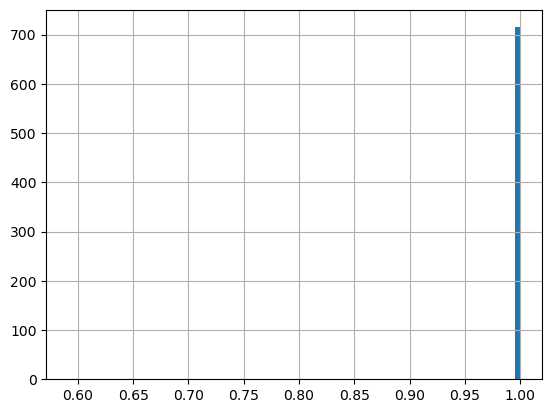

In [51]:
cis_df.qval.hist(bins=100)

### *trans*-QTL mapping

In [ ]:
# run mapping
# to limit output size, only associations with p-value <= 1e-5 are returned
trans_df = trans.map_trans(genotype_df, phenotype_df, covariates_df, batch_size=10000,
                           return_sparse=True, pval_threshold=1e-5, maf_threshold=0.05)

In [28]:
# remove cis-associations
trans_df = trans.filter_cis(trans_df, phenotype_pos_df, variant_df, window=5000000)

In [20]:
trans_df.head()

,variant_id,phenotype_id,pval,b,b_se,af
0,chr1_51479,113324,2.660085e-06,-0.533680,0.031414,0.666667
1,chr1_51479,113325,1.921269e-09,-0.367525,0.006427,0.666667
2,chr1_51479,113352,4.744198e-08,-0.586417,0.017527,0.666667
3,chr1_51479,113965,6.395684e-06,0.595992,0.040731,0.666667
4,chr1_51479,138685,9.522360e-06,-0.370109,0.027076,0.666667


In [52]:
# trans_df.to_csv(f'{prefix}_trans_qtl_pairs.22.csv', index=False)
cis_df.to_csv(f'{prefix}_cis_qtl_pairs.22.csv', index=False)

### 绘图

In [ ]:
trans_df=pd.read_csv(f'{prefix}_trans_qtl_pairs.22.csv')
trans_df['phenotype_id'].value_counts()

In [53]:
# 统计每个样本鉴定的SNP数量
nSNP=(genotype_df>0).sum(axis=0).sort_values(ascending=False)
# 统计每个SNP出现次数的频数
nfreq=(genotype_df>0).sum(axis=1).value_counts()

Text(0.5, 1.0, 'SNP Frequency Distribution')

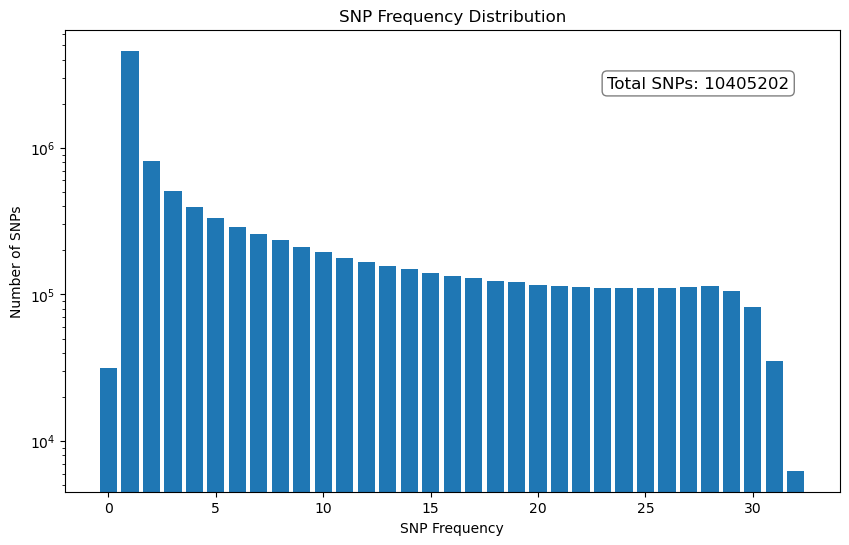

In [54]:
plt.figure(figsize=(10, 6))
plt.bar(nfreq.index, nfreq.values)
plt.yscale('log')
# plt.yticks([ 1e4, 1e5,1e6,1e7])
plt.text(0.7,0.9, f"Total SNPs: {nfreq.sum()}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
# plt.xticks(range(0, 14, 1))
plt.xlabel('SNP Frequency')
plt.ylabel('Number of SNPs')
plt.title('SNP Frequency Distribution')

Text(0.5, 1.0, 'Number of SNPs per samples')

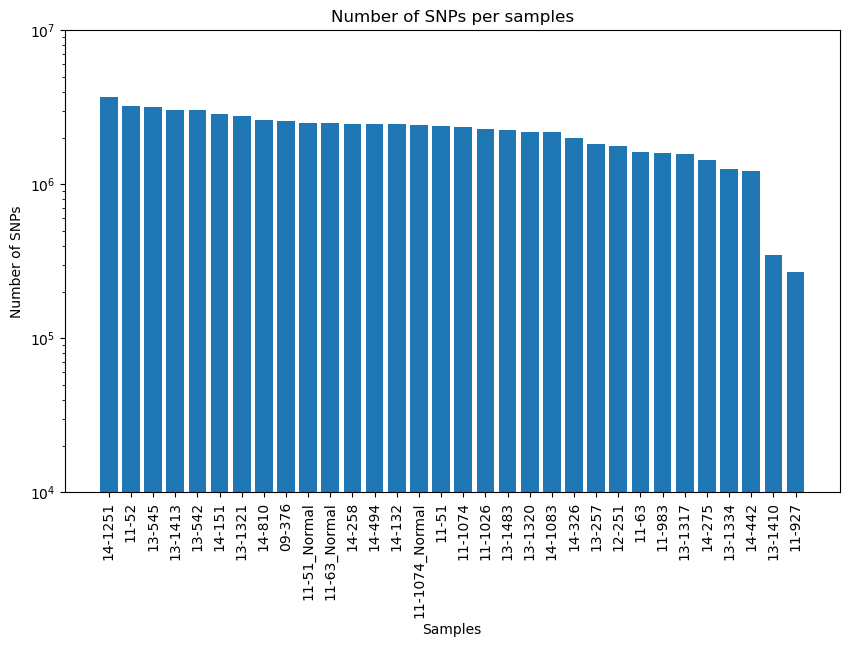

In [35]:
# barplot
plt.figure(figsize=(10, 6))
plt.bar(nSNP.index, nSNP.values)
plt.yscale('log')
plt.xticks(rotation=90)
plt.yticks([ 1e4, 1e5,1e6,1e7])
plt.xlabel('Samples')
plt.ylabel('Number of SNPs')
plt.title('Number of SNPs per samples')

In [ ]:
trans_df.shape,genotype_df.shape,cis_df.shape

In [36]:
pairs_df.head()

,phenotype_id,variant_id,start_distance,end_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se
0,574263,chr22_46085605_C_T,-999396,-1004395,0.5000,32,32,NaN,NaN,NaN
1,574263,rs8135478,-998896,-1003895,0.8000,2,13,0.949320,0.012576,0.195794
2,574263,chr22_46086842_G_C,-998159,-1003158,0.5000,32,32,NaN,NaN,NaN
3,574263,rs9626891,-997933,-1002932,0.5625,31,28,0.595991,-0.117615,0.218890
4,574263,chr22_46087271_G_A,-997730,-1002729,0.5000,32,32,NaN,NaN,NaN


### 手动计算

In [3]:
# phenotype_df.to_csv(f'{prefix}_phenotype_df.22.csv')
# genotype_df.to_csv(f'{prefix}_genotype_df.22.csv')
phenotype_df = pd.read_csv(f'{prefix}_phenotype_df.22.csv', index_col=0)
genotype_df = pd.read_csv(f'{prefix}_genotype_df.22.csv', index_col=0)
pairs_df = pd.read_parquet(f'{prefix}.cis_qtl_pairs.22.parquet')
cis_df = pd.read_csv(f'{prefix}_cis_qtl_pairs.22.csv', index_col=0)

In [55]:
print(f"Phenotype DataFrame shape: {phenotype_df.shape}")
print(f"Genotype DataFrame shape: {genotype_df.shape}")
print(f"Pairs DataFrame shape: {pairs_df.shape}")
print(f"Cis DataFrame shape: {cis_df.shape}")

Phenotype DataFrame shape: (539677, 32)
Genotype DataFrame shape: (10405202, 32)
Pairs DataFrame shape: (6690417, 10)
Cis DataFrame shape: (716, 17)


In [59]:
cis_df.head()

,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval
phenotype_id,,,,,,,,,,,,,,,,,
574263,3151,1.066471,576.776855,20.738218,0.000681,rs454700,592427,587428,6,8,0.875000,0.000341,0.348447,0.082949,0.300770,0.294515,0.99975
574264,3151,1.113155,474.488525,18.313345,0.001288,rs35637220,-881082,-886081,28,17,0.722222,0.000298,-0.791011,0.185912,0.420558,0.403904,0.99975
574265,3161,1.076256,411.445709,18.218555,0.004712,rs4374471,-567098,-572097,29,23,0.636364,0.001452,0.590806,0.163389,0.840016,0.838779,0.99975
574266,3164,1.092622,221.665817,13.682797,0.007830,rs4823607,67280,62281,1,1,0.972222,0.000516,0.795607,0.197195,0.801720,0.799526,0.99975
574267,3166,1.104851,288.316620,16.236423,0.004295,rs1474857,119726,114727,6,16,0.750000,0.000641,-0.410243,0.103934,0.684332,0.671096,0.99975


### actual running

In [10]:
from manual import SNPExpressionAnalyzer
import os

ModuleNotFoundError: No module named 'manual'

In [ ]:
# 04 actual running
analyzer = SNPExpressionAnalyzer()
analyzer.set_data_directly(genotype_df,phenotypedf, cismapdf)
# analyzer.preprocess_genotype()
# 批量分析
print("\n=== 批量分析 ===")
analyzer.batch_analysis(method='t_test')

# 显示汇总统计
print("\n=== 汇总统计 ===")
analyzer.get_summary_statistics()